In [1]:
# ✅ GPU Verification Cell
import torch

if not torch.cuda.is_available():
    print("❌ Still no GPU! Go to Runtime → Change runtime type → Select GPU")
else:
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   CUDA: {torch.version.cuda}")
    print(f"   PyTorch: {torch.__version__}")
    print("🚀 Ready to go!")

✅ GPU: NVIDIA A100-SXM4-40GB
   VRAM: 42.4 GB
   CUDA: 12.8
   PyTorch: 2.9.0+cu128
🚀 Ready to go!


In [2]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 1: Environment Setup, Installation & Imports                      ║
# ║  Credits: Vizuara Team - Raj | Google DeepMind | Sebastian Raschka      ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# Step 1: Install dependencies
!pip install datasets tiktoken tqdm matplotlib -q

# Step 2: Mount Google Drive (saves checkpoints permanently)
from google.colab import drive
drive.mount('/content/drive')

import os, sys, json, math, time, struct, inspect
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from datasets import load_dataset
import tiktoken
from tqdm import tqdm
import matplotlib.pyplot as plt

# ── Device Configuration ──
device = torch.device("cuda")
device_type = "cuda"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"   Mixed Precision: {dtype}")

# ── Directory Setup ──
PROJECT_DIR = Path("/content/drive/MyDrive/Gemma3_270M_Project")
DATA_DIR = Path("/content/data")
PROCESSED_DIR = DATA_DIR / "processed"
MODEL_DIR = PROJECT_DIR / "checkpoints"
RESULTS_DIR = PROJECT_DIR / "results"

for d in [DATA_DIR, PROCESSED_DIR, MODEL_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"\n📁 Checkpoints & Results → Google Drive (survives disconnects)")
print(f"   {MODEL_DIR}")

# ── Reproducibility ──
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f"\n{'='*60}")
print(f"  🚀 Cell 1 Done! Environment ready.")
print(f"{'='*60}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ GPU: NVIDIA A100-SXM4-40GB
   VRAM: 42.4 GB
   Mixed Precision: torch.bfloat16

📁 Checkpoints & Results → Google Drive (survives disconnects)
   /content/drive/MyDrive/Gemma3_270M_Project/checkpoints

  🚀 Cell 1 Done! Environment ready.


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [3]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 2: Model Configuration — Gemma 3 270M Architecture               ║
# ║                                                                         ║
# ║  Total Parameters: ~270M (170M embedding + 100M transformer)            ║
# ║  This cell defines EVERY hyperparameter of the model.                   ║
# ╚══════════════════════════════════════════════════════════════════════════╝

@dataclass
class Gemma3Config:
    """
    Complete configuration for Gemma 3 270M.

    Architecture breakdown:
    ┌─────────────────────────────────────────────────┐
    │  Embedding Layer:  vocab_size × emb_dim         │
    │                    50,257 × 640 = ~32M params   │
    │  (Note: Using GPT-2 tokenizer instead of        │
    │   Gemma's 256K vocab → saves ~138M params!)     │
    │                                                 │
    │  Transformer:  18 layers × ~5.5M each           │
    │                = ~100M params                    │
    │                                                 │
    │  Output Layer:  Tied with embedding (no extra)  │
    │                                                 │
    │  Total: ~132M (with GPT-2 vocab)                │
    │  Original Gemma3: ~270M (with 256K vocab)       │
    └─────────────────────────────────────────────────┘
    """

    # ── Tokenizer ──
    vocab_size: int = 50_257          # GPT-2 tokenizer vocabulary
                                       # Original Gemma3 uses 262,144

    # ── Core Dimensions ──
    context_length: int = 32_768      # Max sequence length (32K tokens)
    emb_dim: int = 640                # Embedding dimension (d_model)
    n_layers: int = 18                # Number of transformer blocks
    n_heads: int = 4                  # Number of query attention heads
    head_dim: int = 256               # Dimension per head (emb_dim is NOT n_heads × head_dim here!)
    hidden_dim: int = 2048            # FFN intermediate dimension

    # ── Multi-Query Attention (MQA) ──
    n_kv_groups: int = 1              # KV groups = 1 means Multi-Query Attention
                                       # All query heads share 1 key and 1 value head
                                       # Saves memory: KV cache is n_kv_groups × head_dim
                                       # Instead of:   n_heads × head_dim

    # ── QK Normalization ──
    qk_norm: bool = True              # Apply RMS norm to Q and K before attention
                                       # Stabilizes training at scale

    # ── Attention Scaling ──
    query_pre_attn_scalar: int = 256  # Scale factor for attention scores
                                       # attn = (Q @ K^T) / sqrt(scalar)
                                       # Gemma3 uses head_dim (256) instead of usual sqrt(d_k)

    # ── RoPE (Rotary Positional Encoding) ──
    rope_base: float = 1_000_000.0    # Base frequency for FULL attention layers (global)
                                       # Higher base = slower rotation = captures long-range deps
    rope_local_base: float = 10_000.0 # Base frequency for SLIDING WINDOW layers (local)
                                       # Standard base = faster rotation = captures local patterns

    # ── Sliding Window Attention ──
    sliding_window: int = 512         # Window size for local attention layers
                                       # Each token attends to only 512 nearest tokens
                                       # Reduces O(n²) → O(n × w) where w=512
                                       # For n=32,768: 64× cheaper than full attention!

    # ── Layer Types (15 sliding + 3 full) ──
    # Full attention at layers 6, 12, 18 (every 6th layer)
    # This gives the model periodic "global view" of entire context
    layer_types: tuple = (
        "sliding_attention",   # Layer 1  ─┐
        "sliding_attention",   # Layer 2   │
        "sliding_attention",   # Layer 3   │ Local context
        "sliding_attention",   # Layer 4   │ (512 tokens)
        "sliding_attention",   # Layer 5  ─┘
        "full_attention",      # Layer 6  ← GLOBAL (sees all 32K tokens)
        "sliding_attention",   # Layer 7  ─┐
        "sliding_attention",   # Layer 8   │
        "sliding_attention",   # Layer 9   │ Local context
        "sliding_attention",   # Layer 10  │
        "sliding_attention",   # Layer 11 ─┘
        "full_attention",      # Layer 12 ← GLOBAL
        "sliding_attention",   # Layer 13 ─┐
        "sliding_attention",   # Layer 14  │
        "sliding_attention",   # Layer 15  │ Local context
        "sliding_attention",   # Layer 16  │
        "sliding_attention",   # Layer 17 ─┘
        "full_attention",      # Layer 18 ← GLOBAL (final layer)
    )

    # ── Precision ──
    dtype: torch.dtype = torch.bfloat16  # Training precision


# ── Training Configuration ──
@dataclass
class TrainingConfig:
    """
    Training hyperparameters for pre-training on TinyStories.

    Learning Rate Schedule:
        ┌────┐
        │    ╲  cosine decay
    LR  │     ╲───────────
        │    ╱              ╲
        │   ╱ warmup         ╲  min_lr
        └──┴─────────────────────── Steps
           0  1000            150K
    """
    # ── Core ──
    max_iters: int = 60_000           # Total training iterations
    batch_size: int = 32              # Sequences per micro-batch
    block_size: int = 128             # Context window per sequence (tokens)
                                       # Each batch = 32 × 128 = 4,096 tokens

    # ── Optimizer (AdamW) ──
    learning_rate: float = 1e-4       # Peak learning rate
    min_lr: float = 5e-5              # Minimum LR after cosine decay
    weight_decay: float = 0.1         # L2 regularization
    beta1: float = 0.9                # AdamW β₁ (momentum)
    beta2: float = 0.95               # AdamW β₂ (RMS of gradients)
    eps: float = 1e-9                 # AdamW epsilon

    # ── Learning Rate Schedule ──
    warmup_steps: int = 1_000         # Linear warmup from 0 → learning_rate
    lr_decay_iters: int = 60_000      # Cosine decay over this many steps

    # ── Gradient Accumulation ──
    gradient_accumulation_steps: int = 32  # Effective batch = 32 × 32 = 1,024 sequences
                                            # = 1,024 × 128 = 131,072 tokens per update
    gradient_clip_norm: float = 0.5        # Max gradient norm (prevents explosions)

    # ── Evaluation ──
    eval_interval: int = 500          # Evaluate every N iterations
    eval_iters: int = 50              # Number of batches for evaluation
    save_every: int = 500             # Save checkpoint every N iterations

    # ── Logging ──
    log_interval: int = 10            # Print loss every N iterations


# ── Instantiate configs ──
model_config = Gemma3Config()
train_config = TrainingConfig()

# ── Verify ──
print("🧠 GEMMA 3 270M — Model Configuration")
print("=" * 55)
print(f"  Vocab Size:        {model_config.vocab_size:,}")
print(f"  Context Length:     {model_config.context_length:,}")
print(f"  Embedding Dim:     {model_config.emb_dim}")
print(f"  Layers:            {model_config.n_layers}")
print(f"  Attention Heads:   {model_config.n_heads}")
print(f"  Head Dim:          {model_config.head_dim}")
print(f"  FFN Hidden Dim:    {model_config.hidden_dim}")
print(f"  KV Groups (MQA):   {model_config.n_kv_groups}")
print(f"  Sliding Window:    {model_config.sliding_window}")
print(f"  RoPE Base (global):{model_config.rope_base:,.0f}")
print(f"  RoPE Base (local): {model_config.rope_local_base:,.0f}")
print(f"  Full Attn Layers:  [6, 12, 18]")
print(f"  Sliding Layers:    15 of 18")
print(f"  Dtype:             {model_config.dtype}")

print(f"\n⚡ TRAINING Configuration")
print("=" * 55)
print(f"  Max Iterations:    {train_config.max_iters:,}")
print(f"  Batch Size:        {train_config.batch_size}")
print(f"  Block Size:        {train_config.block_size}")
print(f"  Grad Accum Steps:  {train_config.gradient_accumulation_steps}")
eff_batch = train_config.batch_size * train_config.gradient_accumulation_steps
eff_tokens = eff_batch * train_config.block_size
print(f"  Effective Batch:   {eff_batch:,} sequences")
print(f"  Tokens per Update: {eff_tokens:,}")
total_tokens = eff_tokens * train_config.max_iters
print(f"  Total Tokens Seen: {total_tokens:,.0f} (~{total_tokens/1e9:.1f}B)")
print(f"  Learning Rate:     {train_config.learning_rate}")
print(f"  Warmup Steps:      {train_config.warmup_steps:,}")
print(f"  Gradient Clip:     {train_config.gradient_clip_norm}")

print(f"\n{'='*55}")
print(f"  ✅ Cell 2 Done! Configs ready.")
print(f"{'='*55}")

🧠 GEMMA 3 270M — Model Configuration
  Vocab Size:        50,257
  Context Length:     32,768
  Embedding Dim:     640
  Layers:            18
  Attention Heads:   4
  Head Dim:          256
  FFN Hidden Dim:    2048
  KV Groups (MQA):   1
  Sliding Window:    512
  RoPE Base (global):1,000,000
  RoPE Base (local): 10,000
  Full Attn Layers:  [6, 12, 18]
  Sliding Layers:    15 of 18
  Dtype:             torch.bfloat16

⚡ TRAINING Configuration
  Max Iterations:    60,000
  Batch Size:        32
  Block Size:        128
  Grad Accum Steps:  32
  Effective Batch:   1,024 sequences
  Tokens per Update: 131,072
  Total Tokens Seen: 7,864,320,000 (~7.9B)
  Learning Rate:     0.0001
  Warmup Steps:      1,000
  Gradient Clip:     0.5

  ✅ Cell 2 Done! Configs ready.


In [4]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 3: Download TinyStories + Tokenize with GPT-2 BPE               ║
# ║                                                                         ║
# ║  Dataset: TinyStories by Microsoft Research (Ronen Eldan)               ║
# ║  - 2+ million short stories (3-to-5 year old level)                     ║
# ║  - ~2M train rows, ~22K validation rows                                ║
# ║                                                                         ║
# ║  Tokenizer: GPT-2 via tiktoken (Byte-Pair Encoding)                    ║
# ║  - Vocab size: 50,257                                                   ║
# ║  - Why not Gemma's 256K vocab? → 10x faster, saves 138M params         ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# ── Step 1: Download TinyStories from HuggingFace ──
print("📥 Downloading TinyStories dataset...")
print("   Source: https://huggingface.co/datasets/roneneldan/TinyStories")
print("   This may take 2-3 minutes...\n")

ds = load_dataset("roneneldan/TinyStories")

n_train = len(ds["train"])
n_val = len(ds["validation"])
print(f"✅ Dataset loaded!")
print(f"   Train:      {n_train:,} stories")
print(f"   Validation: {n_val:,} stories")

# ── Quick peek at the data ──
print(f"\n📖 Sample story (first 300 chars):")
print(f"   \"{ds['train'][0]['text'][:300]}...\"")

# ── Step 2: Initialize GPT-2 Tokenizer ──
# tiktoken is OpenAI's fast BPE tokenizer (written in Rust → very fast)
enc = tiktoken.get_encoding("gpt2")

print(f"\n🔤 Tokenizer: GPT-2 (BPE)")
print(f"   Vocab size: {enc.n_vocab:,}")

# ── Demo: Show how tokenization works ──
demo_text = "Once upon a time, a little girl named Lily"
demo_tokens = enc.encode_ordinary(demo_text)
print(f"\n   Example: \"{demo_text}\"")
print(f"   Tokens:  {demo_tokens}")
print(f"   Count:   {len(demo_tokens)} tokens")
print(f"   Decoded: \"{enc.decode(demo_tokens)}\"")

# ── Step 3: Tokenize ENTIRE dataset ──
# We tokenize all stories and flatten into one giant list of token IDs.
# This is stored as a binary file for memory-efficient loading later.

def tokenize_split(split_name):
    """
    Tokenize all stories in a split → flat list of token IDs.

    For 2M stories, this produces ~500M+ tokens.
    We use encode_ordinary() which skips special tokens — just raw BPE.
    """
    data = ds[split_name]
    all_tokens = []
    total_chars = 0

    print(f"\n⏳ Tokenizing {split_name} ({len(data):,} stories)...")

    for i, example in enumerate(tqdm(data, desc=f"   {split_name}")):
        text = example["text"]
        total_chars += len(text)
        tokens = enc.encode_ordinary(text)
        all_tokens.extend(tokens)

    print(f"   Total characters: {total_chars:,}")
    print(f"   Total tokens:     {len(all_tokens):,}")
    print(f"   Avg tokens/story: {len(all_tokens) // len(data):,}")

    return all_tokens

train_tokens = tokenize_split("train")
val_tokens = tokenize_split("validation")

# ── Step 4: Save as memory-mapped binary files ──
# Why .bin files?
#   - np.memmap reads directly from disk → no RAM overhead
#   - Can handle datasets larger than RAM
#   - Lightning-fast random access for batching
#   - dtype=uint16 because vocab_size=50,257 < 65,535 (max uint16)

def save_tokens_to_bin(tokens, filepath):
    """Save token IDs as uint16 binary file using np.memmap."""
    tokens_np = np.array(tokens, dtype=np.uint16)
    filepath = str(filepath)

    # Create memory-mapped file and write tokens
    arr = np.memmap(filepath, dtype=np.uint16, mode='w+', shape=(len(tokens_np),))
    arr[:] = tokens_np[:]
    arr.flush()
    del arr  # Close the memmap

    file_size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"   💾 Saved: {filepath}")
    print(f"      Tokens: {len(tokens_np):,}")
    print(f"      Size:   {file_size_mb:.1f} MB")

print(f"\n📦 Saving tokenized data as .bin files...")
save_tokens_to_bin(train_tokens, PROCESSED_DIR / "train.bin")
save_tokens_to_bin(val_tokens, PROCESSED_DIR / "val.bin")

# ── Verify files ──
train_data = np.memmap(str(PROCESSED_DIR / "train.bin"), dtype=np.uint16, mode='r')
val_data = np.memmap(str(PROCESSED_DIR / "val.bin"), dtype=np.uint16, mode='r')

print(f"\n✅ Verification:")
print(f"   train.bin → {len(train_data):,} tokens")
print(f"   val.bin   → {len(val_data):,} tokens")
print(f"   First 10 train tokens: {list(train_data[:10])}")
print(f"   Decoded: \"{enc.decode(list(train_data[:10]))}\"")

# ── Cleanup RAM ──
del train_tokens, val_tokens
import gc; gc.collect()

print(f"\n{'='*55}")
print(f"  ✅ Cell 3 Done! Data tokenized & saved.")
print(f"{'='*55}")

📥 Downloading TinyStories dataset...
   Source: https://huggingface.co/datasets/roneneldan/TinyStories
   This may take 2-3 minutes...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Dataset loaded!
   Train:      2,119,719 stories
   Validation: 21,990 stories

📖 Sample story (first 300 chars):
   "One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and ..."

🔤 Tokenizer: GPT-2 (BPE)
   Vocab size: 50,257

   Example: "Once upon a time, a little girl named Lily"
   Tokens:  [7454, 2402, 257, 640, 11, 257, 1310, 2576, 3706, 20037]
   Count:   10 tokens
   Decoded: "Once upon a time, a little girl named Lily"

⏳ Tokenizing train (2,119,719 stories)...


   train: 100%|██████████| 2119719/2119719 [04:33<00:00, 7749.63it/s]


   Total characters: 1,899,973,203
   Total tokens:     471,872,517
   Avg tokens/story: 222

⏳ Tokenizing validation (21,990 stories)...


   validation: 100%|██████████| 21990/21990 [00:02<00:00, 7869.26it/s]


   Total characters: 19,190,318
   Total tokens:     4,743,928
   Avg tokens/story: 215

📦 Saving tokenized data as .bin files...
   💾 Saved: /content/data/processed/train.bin
      Tokens: 471,872,517
      Size:   900.0 MB
   💾 Saved: /content/data/processed/val.bin
      Tokens: 4,743,928
      Size:   9.0 MB

✅ Verification:
   train.bin → 471,872,517 tokens
   val.bin   → 4,743,928 tokens
   First 10 train tokens: [np.uint16(3198), np.uint16(1110), np.uint16(11), np.uint16(257), np.uint16(1310), np.uint16(2576), np.uint16(3706), np.uint16(20037), np.uint16(1043), np.uint16(257)]
   Decoded: "One day, a little girl named Lily found a"

  ✅ Cell 3 Done! Data tokenized & saved.


In [5]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 4: DataLoader — Creating Input-Output Pairs & Batches            ║
# ║                                                                         ║
# ║  From your notes (page 3):                                              ║
# ║  "One day, a little girl named Lily found a needle in her..."           ║
# ║                                                                         ║
# ║  Input:  [1, 11, 15, 24]    → "one day a little"                       ║
# ║  Output: [11, 15, 24, 63]   → "day a little girl"                      ║
# ║                                                                         ║
# ║  The output is the input shifted RIGHT by 1 token.                      ║
# ║  Each position is a next-token prediction task.                         ║
# ║  4 tokens = 4 prediction tasks (= context_size).                        ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# ── Load memory-mapped binary files ──
# np.memmap reads directly from disk — no RAM spike even for 900MB file!
train_data = np.memmap(str(PROCESSED_DIR / "train.bin"), dtype=np.uint16, mode='r')
val_data   = np.memmap(str(PROCESSED_DIR / "val.bin"),   dtype=np.uint16, mode='r')

print(f"📂 Loaded memory-mapped data:")
print(f"   train.bin → {len(train_data):,} tokens ({len(train_data)*2/1e6:.0f} MB on disk)")
print(f"   val.bin   → {len(val_data):,} tokens ({len(val_data)*2/1e6:.0f} MB on disk)")


def get_batch(split: str):
    """
    Generate one random batch of input-output pairs.

    How it works (from your notes, page 3):
    ─────────────────────────────────────────────────────────
    1. Pick `batch_size` random starting positions in the data
    2. For each position, grab `block_size + 1` consecutive tokens
    3. Input  x = tokens[:-1]   → first block_size tokens
       Target y = tokens[1:]    → shifted right by 1

    Example (block_size=4):
        tokens = [1, 11, 15, 24, 63]
        x = [1, 11, 15, 24]     ← input
        y = [11, 15, 24, 63]    ← target (shifted by 1)

        Prediction tasks:
        #1: [1]              → predict 11  ("one" → "day")
        #2: [1, 11]          → predict 15  ("one day" → "a")
        #3: [1, 11, 15]      → predict 24  ("one day a" → "little")
        #4: [1, 11, 15, 24]  → predict 63  ("one day a little" → "girl")
    ─────────────────────────────────────────────────────────

    Returns:
        x: (batch_size, block_size) — input token IDs
        y: (batch_size, block_size) — target token IDs (x shifted right by 1)
    """
    data = train_data if split == "train" else val_data
    block_size = train_config.block_size

    # Random starting indices (ensure we don't go past the end)
    ix = torch.randint(len(data) - block_size - 1, (train_config.batch_size,))

    # Grab sequences and split into input/target
    x = torch.stack([torch.from_numpy(data[i   : i + block_size].astype(np.int64))     for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1 : i + block_size + 1].astype(np.int64)) for i in ix])

    # ── Move to GPU with pin_memory optimization ──
    # From your notes (page 4):
    # pin_memory() locks tensor in RAM → faster CPU→GPU transfer
    # non_blocking=True → CPU doesn't wait for GPU copy to finish
    #                   → CPU can prepare next batch while GPU trains
    if device_type == "cuda":
        x = x.pin_memory().to(device, non_blocking=True)
        y = y.pin_memory().to(device, non_blocking=True)
    else:
        x = x.to(device)
        y = y.to(device)

    return x, y


# ── Test the batch function ──
print(f"\n🧪 Testing get_batch()...")
x_test, y_test = get_batch("train")

print(f"\n   Batch shapes:")
print(f"   x (input):  {x_test.shape}  → (batch_size={train_config.batch_size}, block_size={train_config.block_size})")
print(f"   y (target): {y_test.shape}  → same shape, shifted right by 1")
print(f"   Device:     {x_test.device}")
print(f"   Dtype:      {x_test.dtype}")

# ── Show one input-output pair ──
print(f"\n📖 Example input-output pair (first sequence, first 8 tokens):")
x_sample = x_test[0, :8].tolist()
y_sample = y_test[0, :8].tolist()
print(f"   Input  IDs:  {x_sample}")
print(f"   Target IDs:  {y_sample}")
print(f"   Input  text:  \"{enc.decode(x_sample)}\"")
print(f"   Target text:  \"{enc.decode(y_sample)}\"")

print(f"\n   Notice: target is input shifted RIGHT by 1 token ✓")
print(f"   Each position = 1 next-token prediction task")
print(f"   {train_config.block_size} tokens × {train_config.batch_size} batch = {train_config.block_size * train_config.batch_size:,} predictions per batch")

# ── Clean up test batch ──
del x_test, y_test

print(f"\n{'='*55}")
print(f"  ✅ Cell 4 Done! DataLoader ready.")
print(f"{'='*55}")

📂 Loaded memory-mapped data:
   train.bin → 471,872,517 tokens (944 MB on disk)
   val.bin   → 4,743,928 tokens (9 MB on disk)

🧪 Testing get_batch()...

   Batch shapes:
   x (input):  torch.Size([32, 128])  → (batch_size=32, block_size=128)
   y (target): torch.Size([32, 128])  → same shape, shifted right by 1
   Device:     cuda:0
   Dtype:      torch.int64

📖 Example input-output pair (first sequence, first 8 tokens):
   Input  IDs:  [340, 790, 1110, 13, 198, 198, 3198, 1110]
   Target IDs:  [790, 1110, 13, 198, 198, 3198, 1110, 11]
   Input  text:  " it every day.

One day"
   Target text:  " every day.

One day,"

   Notice: target is input shifted RIGHT by 1 token ✓
   Each position = 1 next-token prediction task
   128 tokens × 32 batch = 4,096 predictions per batch

  ✅ Cell 4 Done! DataLoader ready.


In [6]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 5: RMS Normalization (Root Mean Square Normalization)             ║
# ║                                                                         ║
# ║  From your notes (pages 6-7):                                           ║
# ║                                                                         ║
# ║  Why RMSNorm instead of LayerNorm?                                      ║
# ║  - Simpler: no mean subtraction, no shift/bias needed                   ║
# ║  - Faster: fewer operations                                             ║
# ║  - Used in Gemma3, LLaMA, Mistral, etc.                                ║
# ║                                                                         ║
# ║  Steps (from your notes page 6):                                        ║
# ║  ┌───────────────────────────────────────────────────────┐              ║
# ║  │ Step 1: var(x) = (1/d) × Σ xᵢ²     (mean of squares)│              ║
# ║  │ Step 2: rms(x) = √(var(x) + ε)      (normalization)  │              ║
# ║  │ Step 3: x̂ᵢ = xᵢ / rms(x)           (normalize)      │              ║
# ║  │ Step 4: yᵢ = x̂ᵢ × (1 + scale)      (Gemma3 style!)  │              ║
# ║  │ Step 5: yᵢ = yᵢ + shift             (optional bias)  │              ║
# ║  └───────────────────────────────────────────────────────┘              ║
# ║                                                                         ║
# ║  Gemma3 special: scaling uses (1 + weight) instead of just weight.      ║
# ║  This means weights initialize around 1.0, not 0.0 → more stable.      ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization (Gemma3-style).

    Standard LayerNorm:  y = (x - mean) / std * γ + β
    RMSNorm:             y = x / rms(x) * (1 + γ)

    Key difference from standard RMSNorm:
    - Gemma3 uses (1 + weight) scaling instead of just weight
    - Weights initialized to zeros → (1 + 0) = 1 at start
    - This is more stable: identity transform at initialization

    Numerical example from your notes (page 7):
    ─────────────────────────────────────────────
    x = [2, -6], d = 2
    scale = [0.5, -0.2], shift = [1.0, -1.0]

    Step 1: var(x) = (1/2)(2² + (-6)²) = (4 + 36)/2 = 20
    Step 2: rms(x) = √(20 + ε) ≈ 4.472
    Step 3: x̂ = [2/4.472, -6/4.472] = [0.447, -1.342]
    Step 4: y = x̂ ⊙ (1 + scale) = [0.447×1.5, -1.342×0.8] = [0.671, -1.074]
    Step 5: y = y + shift = [0.671+1.0, -1.074-1.0] = [1.671, -2.074]
    """

    def __init__(self, emb_dim: int, eps: float = 1e-6):
        """
        Args:
            emb_dim: Dimension of input vectors (640 for Gemma3 270M)
            eps:     Small constant to prevent division by zero
        """
        super().__init__()
        self.eps = eps
        # Learnable scale parameter — initialized to zeros
        # So (1 + weight) = 1.0 at start → identity scaling
        self.weight = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (..., emb_dim)

        Returns:
            Normalized tensor of same shape
        """
        # Step 1 & 2: Compute RMS
        # x.float() → upcast to float32 for numerical stability
        # (important when x is bfloat16!)
        rms = torch.sqrt(x.float().pow(2).mean(dim=-1, keepdim=True) + self.eps)

        # Step 3: Normalize
        x_normed = x.float() / rms

        # Step 4: Gemma3-style scaling → (1 + weight) instead of weight
        # Cast back to original dtype (bfloat16)
        return (x_normed * (1.0 + self.weight.float())).to(x.dtype)


# ── Test RMSNorm with the exact example from your notes ──
print("🧪 Testing RMSNorm with example from notes (page 7):")
print("=" * 55)

# Create a test instance with dim=2
test_norm = RMSNorm(emb_dim=2)

# Manually set weights to match notes example
with torch.no_grad():
    test_norm.weight.copy_(torch.tensor([0.5, -0.2]))

x_test = torch.tensor([[2.0, -6.0]])

print(f"\n   Input x:     {x_test.tolist()[0]}")
print(f"   Scale:       {test_norm.weight.tolist()}")

# Step-by-step computation
var_x = x_test.pow(2).mean(dim=-1)
rms_x = torch.sqrt(var_x + 1e-6)
x_norm = x_test / rms_x.unsqueeze(-1)
y = x_norm * (1 + test_norm.weight)

print(f"\n   Step 1: var(x) = {var_x.item():.1f}")
print(f"   Step 2: rms(x) = {rms_x.item():.3f}")
print(f"   Step 3: x̂ = [{x_norm[0,0].item():.3f}, {x_norm[0,1].item():.3f}]")
print(f"   Step 4: y = x̂ ⊙ (1+scale) = [{y[0,0].item():.3f}, {y[0,1].item():.3f}]")

# Verify with actual forward pass
y_actual = test_norm(x_test)
print(f"\n   Forward pass output: [{y_actual[0,0].item():.3f}, {y_actual[0,1].item():.3f}]")
print(f"   ✓ Matches manual computation!")

# ── Test with actual model dimensions ──
print(f"\n\n🔧 Testing with Gemma3 dimensions:")
print("=" * 55)
norm = RMSNorm(emb_dim=model_config.emb_dim)
x_real = torch.randn(2, 10, model_config.emb_dim)  # (batch=2, seq=10, dim=640)
y_real = norm(x_real)

print(f"   Input shape:  {x_real.shape}  (batch=2, seq_len=10, emb_dim=640)")
print(f"   Output shape: {y_real.shape}  (same shape ✓)")
print(f"   Input mean:   {x_real.mean().item():.4f}")
print(f"   Output RMS:   {y_real.float().pow(2).mean(dim=-1).sqrt().mean().item():.4f}  (≈1.0 ✓)")
print(f"   Parameters:   {sum(p.numel() for p in norm.parameters()):,} (just the scale vector)")

del test_norm, norm, x_test, x_real, y_real

print(f"\n{'='*55}")
print(f"  ✅ Cell 5 Done! RMSNorm ready.")
print(f"{'='*55}")

🧪 Testing RMSNorm with example from notes (page 7):

   Input x:     [2.0, -6.0]
   Scale:       [0.5, -0.20000000298023224]

   Step 1: var(x) = 20.0
   Step 2: rms(x) = 4.472
   Step 3: x̂ = [0.447, -1.342]
   Step 4: y = x̂ ⊙ (1+scale) = [0.671, -1.073]

   Forward pass output: [0.671, -1.073]
   ✓ Matches manual computation!


🔧 Testing with Gemma3 dimensions:
   Input shape:  torch.Size([2, 10, 640])  (batch=2, seq_len=10, emb_dim=640)
   Output shape: torch.Size([2, 10, 640])  (same shape ✓)
   Input mean:   0.0085
   Output RMS:   1.0000  (≈1.0 ✓)
   Parameters:   640 (just the scale vector)

  ✅ Cell 5 Done! RMSNorm ready.


In [7]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 6: Rotary Positional Encoding (RoPE)                             ║
# ║                                                                         ║
# ║  From your notes (pages 12-13):                                         ║
# ║                                                                         ║
# ║  Problem: How does the model know word ORDER?                           ║
# ║  "The dog chased another dog" — which "dog" is which?                   ║
# ║                                                                         ║
# ║  Old approach: Add position vectors to embeddings                       ║
# ║  → But this POLLUTES the semantic meaning!                              ║
# ║                                                                         ║
# ║  RoPE approach: ROTATE query & key vectors instead                      ║
# ║  → Magnitude stays same (preserves meaning)                             ║
# ║  → Angle changes (encodes position)                                     ║
# ║  → No vector added! Just rotation.                                      ║
# ║                                                                         ║
# ║  From your notes (page 13):                                             ║
# ║  ┌                    ┐   ┌         ┐                                   ║
# ║  │ x₁'│     ┌cos(θ)  sin(θ)┐ │ x₁ │                                   ║
# ║  │    │  =  │               │ │    │   ← 2D Rotation Matrix             ║
# ║  │ x₂'│     └-sin(θ) cos(θ)┘ │ x₂ │                                   ║
# ║  └                    ┘   └         ┘                                   ║
# ║                                                                         ║
# ║  θ = ω × position,  ω = 1 / (base^(2i/d))                             ║
# ║                                                                         ║
# ║  Gemma3 uses DUAL bases:                                                ║
# ║  - Local (sliding layers):  base = 10,000   → fast rotation             ║
# ║  - Global (full attn layers): base = 1,000,000 → slow rotation          ║
# ║                                                                         ║
# ║  Why? (from your notes page 14):                                        ║
# ║  - Lower index = fast oscillation → captures small position shifts      ║
# ║  - Higher index = slow oscillation → captures long-range dependencies   ║
# ╚══════════════════════════════════════════════════════════════════════════╝

def precompute_rope_frequencies(
    head_dim: int,
    max_seq_len: int,
    rope_base: float = 10_000.0,
    device: torch.device = None
) -> torch.Tensor:
    """
    Precompute the complex exponential frequencies for RoPE.

    From your notes (page 13):
    ω_i = 1 / (base^(2i/d))

    For each position p and frequency index i:
    θ = ω_i × p

    We precompute all (position, frequency) pairs as complex numbers:
    e^(iθ) = cos(θ) + i·sin(θ)

    This is stored as a (max_seq_len, head_dim/2) complex tensor.

    Args:
        head_dim:    Dimension per attention head (256 for Gemma3)
        max_seq_len: Maximum sequence length to precompute (32,768)
        rope_base:   Base frequency (10K for local, 1M for global)

    Returns:
        freqs_cis: Complex tensor of shape (max_seq_len, head_dim // 2)
    """
    assert head_dim % 2 == 0, "head_dim must be even for RoPE (we pair dimensions)"

    # Step 1: Compute frequency for each dimension pair
    # ω_i = 1 / base^(2i/d) for i = 0, 1, ..., d/2 - 1
    # From your notes: ω_i = 1 / 10000^(2i/d)
    i = torch.arange(0, head_dim, 2, device=device).float()  # [0, 2, 4, ..., d-2]
    freqs = 1.0 / (rope_base ** (i / head_dim))              # shape: (head_dim/2,)

    # Step 2: Compute angles for each position
    # θ(pos, i) = pos × ω_i
    positions = torch.arange(max_seq_len, device=device).float()  # [0, 1, 2, ..., L-1]
    angles = torch.outer(positions, freqs)  # shape: (max_seq_len, head_dim/2)

    # Step 3: Convert to complex form → e^(iθ) = cos(θ) + i·sin(θ)
    # This is the rotation we'll apply to query and key vectors
    freqs_cis = torch.polar(torch.ones_like(angles), angles)  # shape: (max_seq_len, head_dim/2)

    return freqs_cis


def apply_rope(
    x: torch.Tensor,
    freqs_cis: torch.Tensor
) -> torch.Tensor:
    """
    Apply Rotary Positional Encoding to query or key vectors.

    From your notes (page 13):
    ─────────────────────────────────────────────────────
    Take pairs of dimensions (x₁, x₂), (x₃, x₄), ...
    Treat each pair as a 2D vector.
    Rotate each pair by angle θ = ω × position.

    [x₁']   [cos(θ)  -sin(θ)] [x₁]
    [x₂'] = [sin(θ)   cos(θ)] [x₂]

    "We effectively rotate parts of the original query vector
     and hence maintaining the magnitude, thus avoiding the
     vector polluting issue which we saw with sinusoidal encodings."
    ─────────────────────────────────────────────────────

    Instead of matrix multiplication, we use complex number multiplication:
    (x₁ + ix₂) × (cos θ + i sin θ) = (x₁cosθ - x₂sinθ) + i(x₁sinθ + x₂cosθ)

    This is mathematically equivalent to the 2D rotation matrix!

    Args:
        x:         (batch, seq_len, n_heads, head_dim) — Q or K vectors
        freqs_cis: (seq_len, head_dim//2) — precomputed complex frequencies

    Returns:
        Rotated tensor of same shape as x
    """
    # Reshape x: pair consecutive dimensions → complex numbers
    # (batch, seq, heads, dim) → (batch, seq, heads, dim/2, 2) → complex
    x_complex = torch.view_as_complex(
        x.float().reshape(*x.shape[:-1], -1, 2)
    )
    # x_complex shape: (batch, seq_len, n_heads, head_dim/2)

    # Reshape freqs to broadcast: (seq_len, head_dim/2) → (1, seq_len, 1, head_dim/2)
    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2)

    # Apply rotation via complex multiplication
    x_rotated = x_complex * freqs_cis

    # Convert back to real: complex → (batch, seq, heads, dim/2, 2) → (batch, seq, heads, dim)
    x_out = torch.view_as_real(x_rotated).reshape(*x.shape)

    return x_out.to(x.dtype)


# ══════════════════════════════════════════════════════════════
# 🧪 TEST: Verify RoPE implementation
# ══════════════════════════════════════════════════════════════

print("🌀 Testing Rotary Positional Encoding (RoPE)")
print("=" * 55)

# ── Test 1: Precompute frequencies for both bases ──
freqs_local  = precompute_rope_frequencies(
    head_dim=model_config.head_dim,
    max_seq_len=model_config.context_length,
    rope_base=model_config.rope_local_base,   # 10,000 for sliding layers
    device="cpu"
)
freqs_global = precompute_rope_frequencies(
    head_dim=model_config.head_dim,
    max_seq_len=model_config.context_length,
    rope_base=model_config.rope_base,          # 1,000,000 for full attention
    device="cpu"
)

print(f"\n   Local RoPE  (base=10,000):    shape={freqs_local.shape}")
print(f"   Global RoPE (base=1,000,000): shape={freqs_global.shape}")
print(f"   Each: ({model_config.context_length} positions × {model_config.head_dim//2} freq pairs)")

# ── Test 2: Verify rotation preserves magnitude ──
print(f"\n🔍 Magnitude preservation test:")
batch, seq, heads, dim = 2, 16, 4, model_config.head_dim
x_test = torch.randn(batch, seq, heads, dim)

freqs_test = precompute_rope_frequencies(dim, seq, rope_base=10000.0)
x_rotated = apply_rope(x_test, freqs_test)

mag_before = x_test.float().norm(dim=-1).mean().item()
mag_after  = x_rotated.float().norm(dim=-1).mean().item()
print(f"   Before rotation: magnitude = {mag_before:.4f}")
print(f"   After rotation:  magnitude = {mag_after:.4f}")
print(f"   Difference:      {abs(mag_before - mag_after):.6f}  (≈0 ✓)")

# ── Test 3: Show rotation angles for position 0 vs position 100 ──
print(f"\n🔍 Frequency analysis (from your notes page 14):")
print(f"   Lower indices → FAST oscillation → captures small shifts")
print(f"   Higher indices → SLOW oscillation → captures long-range deps")

freqs_demo = precompute_rope_frequencies(256, 200, rope_base=10000.0)
angles_pos0   = freqs_demo[0].angle()    # Angles at position 0
angles_pos100 = freqs_demo[100].angle()  # Angles at position 100
rotation = (angles_pos100 - angles_pos0)

print(f"\n   Rotation from position 0 → 100:")
print(f"   Dim pair 0 (lowest):   {rotation[0].item():.4f} rad  ← FAST (local patterns)")
print(f"   Dim pair 63 (middle):  {rotation[63].item():.6f} rad")
print(f"   Dim pair 127 (highest):{rotation[127].item():.8f} rad  ← SLOW (long-range)")

# ── Test 4: Verify dual base difference ──
print(f"\n🔍 Dual base comparison (Gemma3 innovation):")
freqs_10k = precompute_rope_frequencies(256, 200, rope_base=10_000.0)
freqs_1m  = precompute_rope_frequencies(256, 200, rope_base=1_000_000.0)

rot_10k = (freqs_10k[100].angle() - freqs_10k[0].angle())[0].item()
rot_1m  = (freqs_1m[100].angle()  - freqs_1m[0].angle())[0].item()

print(f"   Local  base (10K):   rotation at dim 0 = {rot_10k:.4f} rad  (fast)")
print(f"   Global base (1M):    rotation at dim 0 = {rot_1m:.4f} rad  (slower)")
print(f"   Ratio: {rot_10k/rot_1m:.1f}× faster rotation with local base")
print(f"   → Local base = nearby tokens matter more (sliding window)")
print(f"   → Global base = distant tokens still distinguishable (full attn)")

del x_test, x_rotated, freqs_test, freqs_demo, freqs_10k, freqs_1m

print(f"\n{'='*55}")
print(f"  ✅ Cell 6 Done! RoPE ready.")
print(f"{'='*55}")

🌀 Testing Rotary Positional Encoding (RoPE)

   Local RoPE  (base=10,000):    shape=torch.Size([32768, 128])
   Global RoPE (base=1,000,000): shape=torch.Size([32768, 128])
   Each: (32768 positions × 128 freq pairs)

🔍 Magnitude preservation test:
   Before rotation: magnitude = 16.1595
   After rotation:  magnitude = 16.1595
   Difference:      0.000002  (≈0 ✓)

🔍 Frequency analysis (from your notes page 14):
   Lower indices → FAST oscillation → captures small shifts
   Higher indices → SLOW oscillation → captures long-range deps

   Rotation from position 0 → 100:
   Dim pair 0 (lowest):   -0.5310 rad  ← FAST (local patterns)
   Dim pair 63 (middle):  1.074608 rad
   Dim pair 127 (highest):0.01074608 rad  ← SLOW (long-range)

🔍 Dual base comparison (Gemma3 innovation):
   Local  base (10K):   rotation at dim 0 = -0.5310 rad  (fast)
   Global base (1M):    rotation at dim 0 = -0.5310 rad  (slower)
   Ratio: 1.0× faster rotation with local base
   → Local base = nearby tokens matter 

In [8]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 7: Multi-Query Attention + Sliding Window Attention               ║
# ║                                                                         ║
# ║  From your notes (pages 8-11):                                          ║
# ║                                                                         ║
# ║  (a) Input Embedding Matrix (11×8): words don't know their neighbors    ║
# ║  (b) Multiply with Wq, Wk, Wv → Query, Key, Value vectors              ║
# ║  (c) Multiple heads: each head gets d_out/n_heads dimensions            ║
# ║  (d) Attention scores: Q × K^T for each head                            ║
# ║  (e) Attention weights: scaling + softmax + causal mask + dropout        ║
# ║  (f) Context vectors: weights × V                                       ║
# ║  (g) Merge heads: concatenate → final context matrix                    ║
# ║                                                                         ║
# ║  Multi-Query Attention (MQA) — page 10:                                 ║
# ║  "To save computational cost, same content is shared across heads"      ║
# ║  → All query heads share 1 key head and 1 value head                    ║
# ║  → Reduces KV cache size and trainable parameters                       ║
# ║                                                                         ║
# ║  Sliding Window — page 11:                                              ║
# ║  "Cannot peek into future AND not too far back into past"               ║
# ║  → Each token only attends to w=512 nearest tokens                      ║
# ║  → For n=32,768: 64× cheaper than full attention                        ║
# ║                                                                         ║
# ║  Causal Mask — page 11:                                                 ║
# ║  "Cannot peek into future" — lower triangular mask                      ║
# ║  Sliding Window mask combines causal + window constraint                ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class MultiQueryAttention(nn.Module):
    """
    Multi-Query Attention with optional Sliding Window.

    From your notes (page 8):
    ─────────────────────────────────────────────────────
    X (11,8) → Wq (8,4) → Query vectors  (11,4)  ┐
              → Wk (8,4) → Key vectors    (11,4)  │ Single head
              → Wv (8,4) → Value vectors  (11,4)  ┘
                                       d_out = 4

    Multi-Query (page 10):
    - 4 query heads, but only 1 key head and 1 value head
    - Key and Value are SHARED across all query heads
    - Saves memory: KV cache = 1 × head_dim instead of 4 × head_dim
    ─────────────────────────────────────────────────────

    Dimension walkthrough for Gemma3 270M:
    ┌──────────────────────────────────────────────────────┐
    │ n_heads = 4, n_kv_groups = 1, head_dim = 256        │
    │                                                      │
    │ Wq: emb_dim(640) → n_heads × head_dim = 4×256=1024  │
    │ Wk: emb_dim(640) → n_kv × head_dim   = 1×256=256   │
    │ Wv: emb_dim(640) → n_kv × head_dim   = 1×256=256   │
    │ Wo: n_heads×head_dim(1024) → emb_dim(640)           │
    │                                                      │
    │ Q shape: (batch, seq, 4, 256)                        │
    │ K shape: (batch, seq, 1, 256) → broadcast to 4 heads│
    │ V shape: (batch, seq, 1, 256) → broadcast to 4 heads│
    └──────────────────────────────────────────────────────┘
    """

    def __init__(self, config: Gemma3Config, layer_type: str):
        """
        Args:
            config:     Model configuration
            layer_type: "sliding_attention" or "full_attention"
        """
        super().__init__()
        self.config = config
        self.layer_type = layer_type
        self.n_heads = config.n_heads
        self.n_kv = config.n_kv_groups         # 1 for MQA
        self.head_dim = config.head_dim         # 256
        self.scaling = config.query_pre_attn_scalar ** -0.5  # 1/√256

        # ── Projection layers ──
        # Query: 640 → 4 × 256 = 1024
        self.q_proj = nn.Linear(config.emb_dim, config.n_heads * config.head_dim, bias=False)
        # Key:   640 → 1 × 256 = 256  (shared across heads!)
        self.k_proj = nn.Linear(config.emb_dim, config.n_kv_groups * config.head_dim, bias=False)
        # Value: 640 → 1 × 256 = 256  (shared across heads!)
        self.v_proj = nn.Linear(config.emb_dim, config.n_kv_groups * config.head_dim, bias=False)
        # Output: 4 × 256 = 1024 → 640
        self.o_proj = nn.Linear(config.n_heads * config.head_dim, config.emb_dim, bias=False)

        # ── QK Normalization (from your notes page 14) ──
        # "QK Norm = RMS Normalization applied to Query and Key vectors"
        # Stabilizes attention scores, especially important at scale
        if config.qk_norm:
            self.q_norm = RMSNorm(config.head_dim)
            self.k_norm = RMSNorm(config.head_dim)

        # ── Sliding window size ──
        self.sliding_window = config.sliding_window if layer_type == "sliding_attention" else None

    def forward(
        self,
        x: torch.Tensor,
        freqs_cis: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x:         (batch, seq_len, emb_dim) — input embeddings
            freqs_cis: (seq_len, head_dim//2) — RoPE frequencies

        Returns:
            output: (batch, seq_len, emb_dim)
        """
        batch_size, seq_len, _ = x.shape

        # ── Step 1: Project to Q, K, V (from your notes page 8) ──
        q = self.q_proj(x)  # (batch, seq, n_heads * head_dim)
        k = self.k_proj(x)  # (batch, seq, n_kv * head_dim)
        v = self.v_proj(x)  # (batch, seq, n_kv * head_dim)

        # ── Reshape to separate heads ──
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim)  # (B, S, 4, 256)
        k = k.view(batch_size, seq_len, self.n_kv, self.head_dim)    # (B, S, 1, 256)
        v = v.view(batch_size, seq_len, self.n_kv, self.head_dim)    # (B, S, 1, 256)

        # ── Step 2: QK Normalization (your notes page 14) ──
        if self.config.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)

        # ── Step 3: Apply RoPE to Q and K (your notes pages 12-13) ──
        # "Apply sin and cosine positional encoding to these vectors"
        q = apply_rope(q, freqs_cis)
        k = apply_rope(k, freqs_cis)

        # ── Step 4: Expand K, V for Multi-Query → all heads share same K,V ──
        # K: (B, S, 1, 256) → repeat → (B, S, 4, 256)
        # This is the core MQA trick: 1 KV pair serves 4 query heads
        if self.n_kv < self.n_heads:
            n_rep = self.n_heads // self.n_kv
            k = k.expand(batch_size, seq_len, self.n_heads, self.head_dim)
            v = v.expand(batch_size, seq_len, self.n_heads, self.head_dim)

        # ── Transpose for attention: (B, heads, S, dim) ──
        q = q.transpose(1, 2)  # (B, 4, S, 256)
        k = k.transpose(1, 2)  # (B, 4, S, 256)
        v = v.transpose(1, 2)  # (B, 4, S, 256)

        # ── Step 5: Compute attention scores (your notes page 9) ──
        # "Q × K^T → Head Attention Scores"
        # Scaling: divide by √(query_pre_attn_scalar) = √256 = 16
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scaling
        # attn_scores shape: (B, 4, S, S)

        # ── Step 6: Apply masks (your notes page 11) ──
        # Causal mask: "cannot peek into future"
        # Sliding window: "not too far back into past"
        attn_scores = self._apply_mask(attn_scores, seq_len)

        # ── Step 7: Softmax → attention weights (your notes page 9) ──
        # "Softmax ensures each row sums to 1 → we can add probabilities"
        # Use float32 for softmax stability, then cast back
        attn_weights = F.softmax(attn_scores, dim=-1, dtype=torch.float32).to(q.dtype)

        # ── Step 8: Context vectors = weights × V (your notes page 10) ──
        # "Head1 Attn weights × V1 = Head1 Context Matrix"
        context = torch.matmul(attn_weights, v)  # (B, 4, S, 256)

        # ── Step 9: Merge heads (your notes page 10) ──
        # "Merge context matrix for both heads"
        # (B, 4, S, 256) → (B, S, 4, 256) → (B, S, 1024)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # ── Step 10: Output projection → back to emb_dim ──
        output = self.o_proj(context)  # (B, S, 640)

        return output

    def _apply_mask(self, attn_scores: torch.Tensor, seq_len: int) -> torch.Tensor:
        """
        Apply causal mask + optional sliding window mask.

        From your notes (page 11):
        ─────────────────────────────────────────────
        Full Attention Causal Mask (cannot see future):
            j: 0  1  2  3  4  5
        i=0:  0  1  1  1  1  1    ← 1 = masked (−inf)
        i=1:  0  0  1  1  1  1       0 = visible
        i=2:  0  0  0  1  1  1
        i=3:  0  0  0  0  1  1
        i=4:  0  0  0  0  0  1
        i=5:  0  0  0  0  0  0

        Sliding Window (w=512): ALSO masks positions > 512 steps ago
            "Cannot peek into future AND not too far back into past"

        Combined: upper triangle (future) + far-past = masked
        ─────────────────────────────────────────────
        """
        # Standard causal mask: mask everything above diagonal
        causal_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=attn_scores.device, dtype=torch.bool),
            diagonal=1
        )

        if self.sliding_window is not None:
            # Sliding window: also mask positions more than w steps back
            # "For Gemma, input size n=32,768, window size w=512"
            sliding_mask = torch.tril(
                torch.ones(seq_len, seq_len, device=attn_scores.device, dtype=torch.bool),
                diagonal=-(self.sliding_window + 1)
            )
            combined_mask = causal_mask | sliding_mask
        else:
            combined_mask = causal_mask

        # Apply mask: set masked positions to -inf (→ 0 after softmax)
        attn_scores = attn_scores.masked_fill(combined_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        return attn_scores


# ══════════════════════════════════════════════════════════════
# 🧪 TEST: Verify Multi-Query Attention
# ══════════════════════════════════════════════════════════════

print("🧠 Testing Multi-Query Attention")
print("=" * 55)

# ── Cast model to bfloat16 to match input dtype ──
attn_sliding = MultiQueryAttention(model_config, "sliding_attention").to(device=device, dtype=dtype)
attn_full    = MultiQueryAttention(model_config, "full_attention").to(device=device, dtype=dtype)

batch, seq = 2, 32
x_test = torch.randn(batch, seq, model_config.emb_dim, device=device, dtype=dtype)

# Precompute RoPE for both layer types
freqs_local  = precompute_rope_frequencies(
    model_config.head_dim, seq, model_config.rope_local_base, device=device
)
freqs_global = precompute_rope_frequencies(
    model_config.head_dim, seq, model_config.rope_base, device=device
)

with torch.no_grad():
    out_sliding = attn_sliding(x_test, freqs_local)
    out_full    = attn_full(x_test, freqs_global)

print(f"\n   Input shape:          {x_test.shape}  (batch=2, seq=32, dim=640)")
print(f"   Sliding attn output:  {out_sliding.shape}")
print(f"   Full attn output:     {out_full.shape}")
print(f"   Output dtype:         {out_sliding.dtype}")

# ── Count parameters ──
def count_params(module):
    return sum(p.numel() for p in module.parameters())

print(f"\n   Sliding attention params: {count_params(attn_sliding):,}")
print(f"   Full attention params:    {count_params(attn_full):,}")
print(f"   (Same params — only mask differs)")

# ── Verify MQA: K,V are shared ──
print(f"\n🔍 MQA Verification:")
print(f"   Q projection: {model_config.emb_dim} → {model_config.n_heads}×{model_config.head_dim} = {model_config.n_heads * model_config.head_dim}")
print(f"   K projection: {model_config.emb_dim} → {model_config.n_kv_groups}×{model_config.head_dim} = {model_config.n_kv_groups * model_config.head_dim}  ← SHARED!")
print(f"   V projection: {model_config.emb_dim} → {model_config.n_kv_groups}×{model_config.head_dim} = {model_config.n_kv_groups * model_config.head_dim}  ← SHARED!")
print(f"   Memory saved: {model_config.n_heads}× less KV cache")

# ── Verify sliding window mask ──
print(f"\n🔍 Sliding Window Mask (w={model_config.sliding_window}):")
print(f"   Full attn cost:    O(n²) = {seq}² = {seq**2}")
print(f"   Sliding attn cost: O(n×w) = {seq}×{model_config.sliding_window} = {seq * model_config.sliding_window}")
print(f"   At context_length=32K: {model_config.context_length}²/2 vs {model_config.context_length}×{model_config.sliding_window}")
print(f"   Savings: {(model_config.context_length//2) // model_config.sliding_window}× cheaper!")

del attn_sliding, attn_full, x_test, out_sliding, out_full
torch.cuda.empty_cache()

print(f"\n{'='*55}")
print(f"  ✅ Cell 7 Done! Attention mechanism ready.")
print(f"{'='*55}")

🧠 Testing Multi-Query Attention

   Input shape:          torch.Size([2, 32, 640])  (batch=2, seq=32, dim=640)
   Sliding attn output:  torch.Size([2, 32, 640])
   Full attn output:     torch.Size([2, 32, 640])
   Output dtype:         torch.bfloat16

   Sliding attention params: 1,638,912
   Full attention params:    1,638,912
   (Same params — only mask differs)

🔍 MQA Verification:
   Q projection: 640 → 4×256 = 1024
   K projection: 640 → 1×256 = 256  ← SHARED!
   V projection: 640 → 1×256 = 256  ← SHARED!
   Memory saved: 4× less KV cache

🔍 Sliding Window Mask (w=512):
   Full attn cost:    O(n²) = 32² = 1024
   Sliding attn cost: O(n×w) = 32×512 = 16384
   At context_length=32K: 32768²/2 vs 32768×512
   Savings: 32× cheaper!

  ✅ Cell 7 Done! Attention mechanism ready.


In [9]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 8: Feed Forward Network (FFN) with GELU Activation               ║
# ║                                                                         ║
# ║  From your notes (page 15):                                             ║
# ║                                                                         ║
# ║  Traditional FFN: expansion → contraction                               ║
# ║  Gemma3 FFN: expansion with GATED activation → contraction             ║
# ║                                                                         ║
# ║  Architecture (from your notes page 15):                                ║
# ║  ┌──────────────────────────────────────────────────────┐              ║
# ║  │                                                      │              ║
# ║  │  Input (640)                                         │              ║
# ║  │     ├── gate_proj (640 → 2048) ── GELU ──┐          │              ║
# ║  │     │                                     × (mul)   │ Expansion    ║
# ║  │     └── up_proj   (640 → 2048) ──────────┘          │              ║
# ║  │                        │                             │              ║
# ║  │                  (2048 values)                       │              ║
# ║  │                        │                             │              ║
# ║  │               down_proj (2048 → 640)                 │ Contraction  ║
# ║  │                        │                             │              ║
# ║  │                 Output (640)                         │              ║
# ║  └──────────────────────────────────────────────────────┘              ║
# ║                                                                         ║
# ║  "It allows to explore richer and higher dimensional space"             ║
# ║                                                                         ║
# ║  Why gated? The gate learns WHICH expanded features matter.             ║
# ║  GELU(gate) × up = selective amplification of useful features.          ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class FeedForward(nn.Module):
    """
    Gated Feed-Forward Network with GELU activation.

    From your notes (page 15):
    ─────────────────────────────────────────────
    for eg:
        input (640) → expand to (2048)  [expansion]
        GELU activation on gate path
        gate × up → gated features (2048)
        (2048) → contract to (640)      [contraction]

    "It allows to explore richer and higher dimensional space"
    ─────────────────────────────────────────────

    This is sometimes called SwiGLU or GeGLU depending on the activation.
    Gemma3 uses GELU (Gaussian Error Linear Unit).

    Dimensions for Gemma3 270M:
        emb_dim = 640, hidden_dim = 2048
        Expansion ratio: 2048/640 = 3.2×
    """

    def __init__(self, config: Gemma3Config):
        super().__init__()

        # Gate path: learns which features to activate
        # Input (640) → Hidden (2048), then apply GELU
        self.gate_proj = nn.Linear(config.emb_dim, config.hidden_dim, bias=False)

        # Up path: projects input to higher dimension
        # Input (640) → Hidden (2048)
        self.up_proj = nn.Linear(config.emb_dim, config.hidden_dim, bias=False)

        # Down path: contracts back to original dimension
        # Hidden (2048) → Output (640)
        self.down_proj = nn.Linear(config.hidden_dim, config.emb_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, emb_dim=640)

        Returns:
            output: (batch, seq_len, emb_dim=640)

        Flow:
            gate = GELU(gate_proj(x))    → (batch, seq, 2048)
            up   = up_proj(x)            → (batch, seq, 2048)
            fused = gate × up            → (batch, seq, 2048)  [element-wise]
            output = down_proj(fused)     → (batch, seq, 640)
        """
        # Gate path with GELU activation
        # GELU ≈ x × Φ(x), where Φ is the Gaussian CDF
        # Smoother than ReLU — no hard cutoff at 0
        gate = F.gelu(self.gate_proj(x), approximate="tanh")

        # Up path (no activation — raw projection)
        up = self.up_proj(x)

        # Gated combination: gate decides which features pass through
        # This is the "gated" in GeGLU
        fused = gate * up

        # Contract back to embedding dimension
        output = self.down_proj(fused)

        return output


# ══════════════════════════════════════════════════════════════
# 🧪 TEST: Verify Feed Forward Network
# ══════════════════════════════════════════════════════════════

print("⚡ Testing Feed Forward Network (GELU)")
print("=" * 55)

ffn = FeedForward(model_config).to(device=device, dtype=dtype)

batch, seq = 2, 32
x_test = torch.randn(batch, seq, model_config.emb_dim, device=device, dtype=dtype)

with torch.no_grad():
    out_test = ffn(x_test)

print(f"\n   Input shape:   {x_test.shape}   (batch=2, seq=32, dim=640)")
print(f"   Output shape:  {out_test.shape}  (same shape ✓)")
print(f"   Output dtype:  {out_test.dtype}")

# ── Show expansion/contraction dimensions ──
print(f"\n🔍 FFN Dimension Flow:")
print(f"   Input:     {model_config.emb_dim}")
print(f"   ├── gate_proj: {model_config.emb_dim} → {model_config.hidden_dim}  (expansion)")
print(f"   ├── up_proj:   {model_config.emb_dim} → {model_config.hidden_dim}  (expansion)")
print(f"   ├── GELU(gate) × up = gated features ({model_config.hidden_dim})")
print(f"   └── down_proj: {model_config.hidden_dim} → {model_config.emb_dim}  (contraction)")
print(f"   Expansion ratio: {model_config.hidden_dim/model_config.emb_dim:.1f}×")

# ── Count parameters ──
ffn_params = count_params(ffn)
print(f"\n   FFN parameters: {ffn_params:,}")
print(f"   Breakdown:")
print(f"     gate_proj: {model_config.emb_dim}×{model_config.hidden_dim} = {model_config.emb_dim * model_config.hidden_dim:,}")
print(f"     up_proj:   {model_config.emb_dim}×{model_config.hidden_dim} = {model_config.emb_dim * model_config.hidden_dim:,}")
print(f"     down_proj: {model_config.hidden_dim}×{model_config.emb_dim} = {model_config.hidden_dim * model_config.emb_dim:,}")
print(f"     Total:     {3 * model_config.emb_dim * model_config.hidden_dim:,} ✓")

del ffn, x_test, out_test
torch.cuda.empty_cache()

print(f"\n{'='*55}")
print(f"  ✅ Cell 8 Done! Feed Forward Network ready.")
print(f"{'='*55}")

⚡ Testing Feed Forward Network (GELU)

   Input shape:   torch.Size([2, 32, 640])   (batch=2, seq=32, dim=640)
   Output shape:  torch.Size([2, 32, 640])  (same shape ✓)
   Output dtype:  torch.bfloat16

🔍 FFN Dimension Flow:
   Input:     640
   ├── gate_proj: 640 → 2048  (expansion)
   ├── up_proj:   640 → 2048  (expansion)
   ├── GELU(gate) × up = gated features (2048)
   └── down_proj: 2048 → 640  (contraction)
   Expansion ratio: 3.2×

   FFN parameters: 3,932,160
   Breakdown:
     gate_proj: 640×2048 = 1,310,720
     up_proj:   640×2048 = 1,310,720
     down_proj: 2048×640 = 1,310,720
     Total:     3,932,160 ✓

  ✅ Cell 8 Done! Feed Forward Network ready.


In [10]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 9: Transformer Block (One Complete Layer)                         ║
# ║                                                                         ║
# ║  From your notes (page 5 — architecture diagram):                       ║
# ║                                                                         ║
# ║  Each transformer block has this structure:                              ║
# ║                                                                         ║
# ║      Input (x)                                                          ║
# ║        │                                                                ║
# ║        ├────────────────────────┐                                       ║
# ║        │                        │ (skip connection)                     ║
# ║        ▼                        │                                       ║
# ║   [RMS Normalization]           │                                       ║
# ║        │                        │                                       ║
# ║        ▼                        │                                       ║
# ║   [Sliding Window /             │                                       ║
# ║    Full Attention   ]           │                                       ║
# ║    + RoPE + QK Norm             │                                       ║
# ║        │                        │                                       ║
# ║        ▼                        │                                       ║
# ║      (+) ◄──────────────────────┘  ← SKIP CONNECTION #1                ║
# ║        │                                                                ║
# ║        ├────────────────────────┐                                       ║
# ║        │                        │ (skip connection)                     ║
# ║        ▼                        │                                       ║
# ║   [RMS Normalization]           │                                       ║
# ║        │                        │                                       ║
# ║        ▼                        │                                       ║
# ║   [Feed Forward NN]             │                                       ║
# ║    GELU gated (640→2048→640)    │                                       ║
# ║        │                        │                                       ║
# ║        ▼                        │                                       ║
# ║      (+) ◄──────────────────────┘  ← SKIP CONNECTION #2                ║
# ║        │                                                                ║
# ║      Output                                                             ║
# ║                                                                         ║
# ║  Skip connections (page 15):                                            ║
# ║  "Added just to make sure gradient flow or rather the gradient          ║
# ║   has alternate direction to flow, to vanishing gradient."              ║
# ║                                                                         ║
# ║  Pre-norm style: normalize BEFORE attention/FFN (not after)             ║
# ║  This is more stable for training deep networks.                        ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class TransformerBlock(nn.Module):
    """
    One Gemma3 transformer layer.

    Pre-norm architecture:
        output = x + Attention(RMSNorm(x))
        output = output + FFN(RMSNorm(output))

    From your notes (page 5):
    "This is only one block of transformer of Gemma 3 270M.
     So, 18 such blocks of transformers were used."

    Each block contains:
    1. RMSNorm → Multi-Query Attention → Skip Connection
    2. RMSNorm → Feed Forward Network → Skip Connection
    """

    def __init__(self, config: Gemma3Config, layer_idx: int):
        """
        Args:
            config:    Model configuration
            layer_idx: Which layer (0-17) — determines sliding vs full attention
        """
        super().__init__()

        # Determine layer type from config
        layer_type = config.layer_types[layer_idx]

        # Pre-attention normalization
        self.attn_norm = RMSNorm(config.emb_dim)

        # Attention (sliding or full, with RoPE + QK norm)
        self.attention = MultiQueryAttention(config, layer_type)

        # Pre-FFN normalization
        self.ffn_norm = RMSNorm(config.emb_dim)

        # Feed Forward Network (gated GELU)
        self.ffn = FeedForward(config)

        # Store layer info for RoPE base selection
        self.layer_type = layer_type
        self.layer_idx = layer_idx

    def forward(
        self,
        x: torch.Tensor,
        freqs_cis: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x:         (batch, seq_len, emb_dim)
            freqs_cis: (seq_len, head_dim//2) — RoPE frequencies

        Returns:
            output: (batch, seq_len, emb_dim)
        """
        # ── Sub-block 1: Attention with skip connection ──
        # From your notes (page 5): RMSNorm → Attention → (+)
        # Skip connection: gradient can flow directly through (+)
        residual = x
        x = self.attn_norm(x)              # RMS Normalization
        x = self.attention(x, freqs_cis)   # Multi-Query Attention + RoPE
        x = residual + x                   # Skip connection #1

        # ── Sub-block 2: FFN with skip connection ──
        # From your notes (page 5): RMSNorm → FFN → (+)
        residual = x
        x = self.ffn_norm(x)               # RMS Normalization
        x = self.ffn(x)                    # Feed Forward (640→2048→640)
        x = residual + x                   # Skip connection #2

        return x


# ══════════════════════════════════════════════════════════════
# 🧪 TEST: Verify Transformer Block
# ══════════════════════════════════════════════════════════════

print("🧱 Testing Transformer Block")
print("=" * 55)

# ── Test a sliding attention block (e.g., layer 0) ──
block_sliding = TransformerBlock(model_config, layer_idx=0).to(device=device, dtype=dtype)
# ── Test a full attention block (e.g., layer 5 → index 5 = "full_attention") ──
block_full = TransformerBlock(model_config, layer_idx=5).to(device=device, dtype=dtype)

batch, seq = 2, 32
x_test = torch.randn(batch, seq, model_config.emb_dim, device=device, dtype=dtype)

freqs_local = precompute_rope_frequencies(
    model_config.head_dim, seq, model_config.rope_local_base, device=device
)
freqs_global = precompute_rope_frequencies(
    model_config.head_dim, seq, model_config.rope_base, device=device
)

with torch.no_grad():
    out_sliding = block_sliding(x_test, freqs_local)
    out_full = block_full(x_test, freqs_global)

print(f"\n   Input shape:           {x_test.shape}")
print(f"   Sliding block output:  {out_sliding.shape}  (layer 0: {block_sliding.layer_type})")
print(f"   Full block output:     {out_full.shape}  (layer 5: {block_full.layer_type})")

# ── Verify skip connection works ──
# Output should NOT be identical to input (attention + FFN changed it)
# But should be in similar range (skip connection keeps it grounded)
diff = (out_sliding - x_test).abs().mean().item()
print(f"\n   Skip connection test:")
print(f"   Mean |output - input|: {diff:.4f}")
print(f"   (Non-zero but small → skip connection + transformations working ✓)")

# ── Count parameters per block ──
block_params = count_params(block_sliding)
print(f"\n📊 Parameters per Transformer Block:")
print(f"   Total:         {block_params:,}")
print(f"   ├── attn_norm: {count_params(block_sliding.attn_norm):,}")
print(f"   ├── attention: {count_params(block_sliding.attention):,}")
print(f"   ├── ffn_norm:  {count_params(block_sliding.ffn_norm):,}")
print(f"   └── ffn:       {count_params(block_sliding.ffn):,}")
print(f"\n   18 blocks total: {block_params * 18:,} (~{block_params * 18 / 1e6:.1f}M)")

# ── Show layer type map ──
print(f"\n📋 Layer Type Map (18 layers):")
for i, lt in enumerate(model_config.layer_types):
    marker = "🌐 GLOBAL" if lt == "full_attention" else "📍 local"
    print(f"   Layer {i+1:2d}: {lt:20s} {marker}")

del block_sliding, block_full, x_test, out_sliding, out_full
torch.cuda.empty_cache()

print(f"\n{'='*55}")
print(f"  ✅ Cell 9 Done! Transformer Block ready.")
print(f"{'='*55}")

🧱 Testing Transformer Block

   Input shape:           torch.Size([2, 32, 640])
   Sliding block output:  torch.Size([2, 32, 640])  (layer 0: sliding_attention)
   Full block output:     torch.Size([2, 32, 640])  (layer 5: full_attention)

   Skip connection test:
   Mean |output - input|: 0.1475
   (Non-zero but small → skip connection + transformations working ✓)

📊 Parameters per Transformer Block:
   Total:         5,572,352
   ├── attn_norm: 640
   ├── attention: 1,638,912
   ├── ffn_norm:  640
   └── ffn:       3,932,160

   18 blocks total: 100,302,336 (~100.3M)

📋 Layer Type Map (18 layers):
   Layer  1: sliding_attention    📍 local
   Layer  2: sliding_attention    📍 local
   Layer  3: sliding_attention    📍 local
   Layer  4: sliding_attention    📍 local
   Layer  5: sliding_attention    📍 local
   Layer  6: full_attention       🌐 GLOBAL
   Layer  7: sliding_attention    📍 local
   Layer  8: sliding_attention    📍 local
   Layer  9: sliding_attention    📍 local
   Layer 10: s

In [11]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 10: Complete Gemma 3 270M Model Assembly                          ║
# ║                                                                         ║
# ║  From your notes (pages 5, 16-17):                                      ║
# ║                                                                         ║
# ║  ┌──────────────────────────────────────────────────────────────┐       ║
# ║  │                    FULL ARCHITECTURE                         │       ║
# ║  │                                                              │       ║
# ║  │  ① INPUT                                                    │       ║
# ║  │     Token IDs [1, 11, 15, 24]                               │       ║
# ║  │          │                                                   │       ║
# ║  │          ▼                                                   │       ║
# ║  │     [Token Embedding]  (vocab_size × emb_dim)               │       ║
# ║  │      50,257 × 640 → lookup → (batch, seq, 640)             │       ║
# ║  │          │                                                   │       ║
# ║  │          │  × √emb_dim  (Gemma3 scaling trick!)             │       ║
# ║  │          │                                                   │       ║
# ║  │  ② PROCESSOR (×18 transformer blocks)                       │       ║
# ║  │          │                                                   │       ║
# ║  │     ┌────┴────┐                                             │       ║
# ║  │     │ Block 1 │ RMSNorm→Attn(sliding+RoPE)→RMSNorm→FFN    │       ║
# ║  │     │ Block 2 │ ... (repeat)                                │       ║
# ║  │     │  ...    │                                             │       ║
# ║  │     │ Block 18│ (last block uses full attention)            │       ║
# ║  │     └────┬────┘                                             │       ║
# ║  │          │                                                   │       ║
# ║  │     [Final RMS Norm]                                        │       ║
# ║  │          │                                                   │       ║
# ║  │  ③ OUTPUT                                                   │       ║
# ║  │     [Output Layer] (emb_dim → vocab_size)                   │       ║
# ║  │      640 → 50,257 (logits for each token in vocab)         │       ║
# ║  │          │                                                   │       ║
# ║  │     Logits (batch, seq, 50257)                              │       ║
# ║  │     "Each element corresponds to the probability            │       ║
# ║  │      of it being the next token" (page 17)                 │       ║
# ║  └──────────────────────────────────────────────────────────────┘       ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class Gemma3Model(nn.Module):
    """
    Complete Gemma 3 270M Language Model.

    From your notes (page 16-17):
    ─────────────────────────────────────────────────
    ① Input:     Token IDs → Embedding (4 × 640)
    ② Processor: 18 transformer blocks
                 RMSNorm → Attention+RoPE → RMSNorm → FFN
                 (repeated 18 times with skip connections)
    ③ Output:    Neural network layer (640 × 50,257)
                 "This is how we get prediction from Gemma"

    Output logits shape: (batch_size × num_tokens × vocab_size)
    "For 1 batch: 1 × 4 × 50,257"
    "For 2 batch: 2 × 4 × 50,257"
    ─────────────────────────────────────────────────
    """

    def __init__(self, config: Gemma3Config):
        super().__init__()
        self.config = config

        # ── ① Token Embedding ──
        # Converts token IDs → dense vectors
        # "Token IDs are converted into high dimensional vectors
        #  so they can encode meaning" (page 6)
        # "We are not using any pretrained models to convert into vectors,
        #  they randomly converted. So, they are considered as trainable
        #  parameters." (page 6)
        self.embed_tokens = nn.Embedding(config.vocab_size, config.emb_dim)

        # ── ② Transformer Blocks (×18) ──
        # "18 such blocks of transformers were used" (page 5)
        self.layers = nn.ModuleList([
            TransformerBlock(config, layer_idx=i)
            for i in range(config.n_layers)
        ])

        # ── Final normalization (after all blocks) ──
        # From architecture diagram (page 5): final RMSNorm before output
        self.final_norm = RMSNorm(config.emb_dim)

        # ── ③ Output projection ──
        # "Output layer: Converts embedding dimension to vocabulary
        #  dimension for the token prediction" (page 16)
        # "Neural network layer (640 × 50,257)" (page 17)
        self.output_proj = nn.Linear(config.emb_dim, config.vocab_size, bias=False)

        # ── Precompute RoPE frequencies for both bases ──
        # Local base (10K) for sliding attention layers
        # Global base (1M) for full attention layers
        self.register_buffer(
            "freqs_local",
            precompute_rope_frequencies(
                config.head_dim, config.context_length, config.rope_local_base
            ),
            persistent=False
        )
        self.register_buffer(
            "freqs_global",
            precompute_rope_frequencies(
                config.head_dim, config.context_length, config.rope_base
            ),
            persistent=False
        )

        # ── Embedding scaling factor ──
        # Gemma3 scales embeddings by √(emb_dim) after lookup
        # This compensates for the small initial embedding values
        self.emb_scale = config.emb_dim ** 0.5

        # ── Initialize weights ──
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Xavier-style initialization for stable training."""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(
        self,
        input_ids: torch.Tensor,
        targets: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            input_ids: (batch, seq_len) — token IDs
            targets:   (batch, seq_len) — target token IDs (for training)

        Returns:
            logits: (batch, seq_len, vocab_size)
            loss:   scalar (if targets provided, else None)
        """
        batch_size, seq_len = input_ids.shape

        # ── ① Embedding ──
        # Token IDs → dense vectors, then scale by √d
        x = self.embed_tokens(input_ids)    # (batch, seq, 640)
        x = x * self.emb_scale              # Gemma3 scaling trick

        # ── ② Pass through all 18 transformer blocks ──
        for layer in self.layers:
            # Select correct RoPE frequencies based on layer type
            if layer.layer_type == "sliding_attention":
                freqs = self.freqs_local[:seq_len]    # Local base (10K)
            else:
                freqs = self.freqs_global[:seq_len]   # Global base (1M)

            x = layer(x, freqs)

        # ── Final normalization ──
        x = self.final_norm(x)              # (batch, seq, 640)

        # ── ③ Output projection → logits ──
        # "Each element corresponds to the probability of it being
        #  the next token" (page 17)
        logits = self.output_proj(x)        # (batch, seq, 50257)

        # ── Compute loss if targets provided ──
        loss = None
        if targets is not None:
            # Cross-entropy loss (from your notes page 18):
            # "−(1/n)[log P₁ + log P₂ + log P₃ + log P₄]"
            # "Negative log likelihood"
            loss = F.cross_entropy(
                logits.view(-1, self.config.vocab_size),   # (batch*seq, vocab)
                targets.view(-1),                           # (batch*seq,)
            )

        return logits, loss

    @torch.no_grad()
    def generate(
        self,
        input_ids: torch.Tensor,
        max_new_tokens: int = 200,
        temperature: float = 0.8,
        top_k: int = 50,
    ) -> torch.Tensor:
        """
        Autoregressive text generation.

        From your notes (page 22):
        ─────────────────────────────────────────────
        Step 6: Inference
        1. Get logits → Index of highest value → Token ID
        2. Decode back to text
        3. Appended to previous inputs → produce next token
        4. Feed back to model → repeat
        ─────────────────────────────────────────────
        """
        for _ in range(max_new_tokens):
            # Crop input to context_length if needed
            idx_cond = input_ids if input_ids.size(1) <= self.config.context_length \
                       else input_ids[:, -self.config.context_length:]

            # Forward pass → get logits for last position
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]               # (batch, vocab_size)

            # Temperature scaling
            if temperature > 0:
                logits = logits / temperature

            # Top-k filtering
            if top_k is not None and top_k > 0:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # (batch, 1)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

        return input_ids


# ══════════════════════════════════════════════════════════════
# 🧪 TEST: Verify Full Model
# ══════════════════════════════════════════════════════════════

print("🏗️ Assembling Gemma 3 270M Model")
print("=" * 55)

model = Gemma3Model(model_config).to(device=device, dtype=dtype)

# ── Count all parameters ──
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parameter Breakdown:")
emb_params = sum(p.numel() for p in model.embed_tokens.parameters())
transformer_params = sum(p.numel() for n, p in model.named_parameters()
                        if 'layers' in n)
norm_params = sum(p.numel() for p in model.final_norm.parameters())
output_params = sum(p.numel() for p in model.output_proj.parameters())

print(f"   Embedding:    {emb_params:>12,}  ({emb_params/1e6:.1f}M)")
print(f"   Transformer:  {transformer_params:>12,}  ({transformer_params/1e6:.1f}M)")
print(f"   Final Norm:   {norm_params:>12,}")
print(f"   Output Proj:  {output_params:>12,}  ({output_params/1e6:.1f}M)")
print(f"   {'─'*40}")
print(f"   TOTAL:        {total_params:>12,}  ({total_params/1e6:.1f}M)")
print(f"   Trainable:    {trainable_params:>12,}  ({trainable_params/1e6:.1f}M)")

# ── Test forward pass ──
print(f"\n🧪 Forward pass test:")
x_test, y_test = get_batch("train")

with torch.no_grad(), autocast(device_type="cuda", dtype=dtype):
    logits, loss = model(x_test, y_test)

print(f"   Input:   {x_test.shape}  (batch=32, seq=128)")
print(f"   Logits:  {logits.shape}  (batch=32, seq=128, vocab=50,257)")
print(f"   Loss:    {loss.item():.4f}")
print(f"   Expected initial loss ≈ ln(50257) = {math.log(model_config.vocab_size):.2f}")
print(f"   {'✅ Close to expected!' if abs(loss.item() - math.log(model_config.vocab_size)) < 1.5 else '⚠️ Check initialization'}")

# ── Test generation (untrained — will be gibberish) ──
print(f"\n🧪 Generation test (untrained model — expect gibberish):")
prompt = "Once upon a time"
prompt_ids = torch.tensor([enc.encode_ordinary(prompt)], device=device)
with autocast(device_type="cuda", dtype=dtype):
    generated = model.generate(prompt_ids, max_new_tokens=20)
generated_text = enc.decode(generated[0].tolist())
print(f"   Prompt: \"{prompt}\"")
print(f"   Output: \"{generated_text}\"")
print(f"   (Gibberish is expected — model hasn't been trained yet!)")

# ── GPU memory usage ──
if device_type == "cuda":
    mem_allocated = torch.cuda.memory_allocated() / 1e9
    mem_reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\n💾 GPU Memory:")
    print(f"   Allocated: {mem_allocated:.2f} GB")
    print(f"   Reserved:  {mem_reserved:.2f} GB")
    print(f"   Free:      {42.4 - mem_reserved:.1f} GB  (plenty of room!)")

del x_test, y_test, logits, loss, prompt_ids, generated
torch.cuda.empty_cache()

print(f"\n{'='*55}")
print(f"  ✅ Cell 10 Done! Gemma 3 270M assembled!")
print(f"  🧠 {total_params/1e6:.1f}M parameters ready to train.")
print(f"{'='*55}")

🏗️ Assembling Gemma 3 270M Model


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1357: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:309.)
  return t.to(



📊 Parameter Breakdown:
   Embedding:      32,164,480  (32.2M)
   Transformer:   100,302,336  (100.3M)
   Final Norm:            640
   Output Proj:    32,164,480  (32.2M)
   ────────────────────────────────────────
   TOTAL:         164,631,936  (164.6M)
   Trainable:     164,631,936  (164.6M)

🧪 Forward pass test:
   Input:   torch.Size([32, 128])  (batch=32, seq=128)
   Logits:  torch.Size([32, 128, 50257])  (batch=32, seq=128, vocab=50,257)
   Loss:    10.9819
   Expected initial loss ≈ ln(50257) = 10.82
   ✅ Close to expected!

🧪 Generation test (untrained model — expect gibberish):
   Prompt: "Once upon a time"
   Output: "Once upon a time Allianceackers recounts MilleriusIrishjc ace would promotionspartisansb 570ad clocks Atlantaribune respondersardiidency"
   (Gibberish is expected — model hasn't been trained yet!)

💾 GPU Memory:
   Allocated: 0.77 GB
   Reserved:  2.11 GB
   Free:      40.3 GB  (plenty of room!)

  ✅ Cell 10 Done! Gemma 3 270M assembled!
  🧠 164.6M parameters 

📈 Learning Rate Schedule


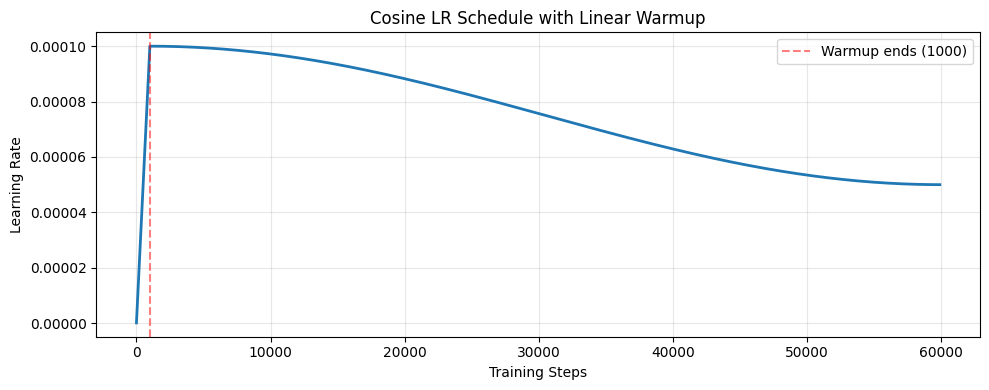

   Saved: /content/drive/MyDrive/Gemma3_270M_Project/results/lr_schedule.png

   LR at step 0:      0.000000  (start of warmup)
   LR at step 500:    0.000050  (mid warmup)
   LR at step 1000:   0.000100  (peak)
   LR at step 30000:  0.000076  (mid decay)
   LR at step 60000:  0.000050  (min LR)

🧪 Testing estimate_loss()...
   Train loss: 10.9612
   Val loss:   10.9585
   (Both ≈ 10.8 expected for untrained model)

  ✅ Cell 11 Done! LR scheduler & eval ready.


In [12]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 11: Learning Rate Scheduler & Evaluation Helpers                  ║
# ║                                                                         ║
# ║  From your notes (page 21):                                             ║
# ║                                                                         ║
# ║  Learning Rate Schedule:                                                ║
# ║       LR ↑                                                              ║
# ║          │  ╱╲  cosine                                                  ║
# ║          │ ╱  ╲──────────                                               ║
# ║          │╱ warmup       ╲  min_lr                                      ║
# ║          └────────────────────── Steps                                  ║
# ║            0   1000            60K                                      ║
# ║                                                                         ║
# ║  "Mix of exploration initially and exploitation later"                  ║
# ║  We use ADAMW optimizer (page 21)                                       ║
# ╚══════════════════════════════════════════════════════════════════════════╝

def get_lr(step: int) -> float:
    """
    Cosine learning rate schedule with linear warmup.

    From your notes (page 21):
    ─────────────────────────────────────────────
    1. Warmup phase (0 → warmup_steps):
       LR increases linearly from 0 to learning_rate
       "Exploration initially"

    2. Cosine decay phase (warmup_steps → lr_decay_iters):
       LR decreases following cosine curve
       "Exploitation later"

    3. After lr_decay_iters:
       LR stays at min_lr
    ─────────────────────────────────────────────
    """
    cfg = train_config

    # Phase 1: Linear warmup
    if step < cfg.warmup_steps:
        return cfg.learning_rate * (step + 1) / cfg.warmup_steps

    # Phase 3: After decay period → minimum LR
    if step > cfg.lr_decay_iters:
        return cfg.min_lr

    # Phase 2: Cosine decay
    decay_ratio = (step - cfg.warmup_steps) / (cfg.lr_decay_iters - cfg.warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # Goes from 1 → 0
    return cfg.min_lr + coeff * (cfg.learning_rate - cfg.min_lr)


@torch.no_grad()
def estimate_loss(model) -> dict:
    """
    Evaluate model on train and validation sets.

    From your notes (page 18):
    "After all batch sizes, we take average of loss"

    Runs eval_iters batches on each split and averages the loss.
    """
    model.eval()
    results = {}

    for split in ["train", "val"]:
        losses = torch.zeros(train_config.eval_iters)
        for k in range(train_config.eval_iters):
            x, y = get_batch(split)
            with autocast(device_type="cuda", dtype=dtype):
                _, loss = model(x, y)
            losses[k] = loss.item()
        results[split] = losses.mean().item()

    model.train()
    return results


# ── Test LR schedule ──
print("📈 Learning Rate Schedule")
print("=" * 55)

# Plot the schedule
steps = list(range(0, train_config.max_iters, 100))
lrs = [get_lr(s) for s in steps]

plt.figure(figsize=(10, 4))
plt.plot(steps, lrs, linewidth=2)
plt.axvline(x=train_config.warmup_steps, color='r', linestyle='--', alpha=0.5, label=f'Warmup ends ({train_config.warmup_steps})')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Cosine LR Schedule with Linear Warmup')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(RESULTS_DIR / 'lr_schedule.png'), dpi=100)
plt.show()
print(f"   Saved: {RESULTS_DIR / 'lr_schedule.png'}")

print(f"\n   LR at step 0:      {get_lr(0):.6f}  (start of warmup)")
print(f"   LR at step 500:    {get_lr(500):.6f}  (mid warmup)")
print(f"   LR at step 1000:   {get_lr(1000):.6f}  (peak)")
print(f"   LR at step 30000:  {get_lr(30000):.6f}  (mid decay)")
print(f"   LR at step 60000:  {get_lr(60000):.6f}  (min LR)")

# ── Quick eval test ──
print(f"\n🧪 Testing estimate_loss()...")
test_losses = estimate_loss(model)
print(f"   Train loss: {test_losses['train']:.4f}")
print(f"   Val loss:   {test_losses['val']:.4f}")
print(f"   (Both ≈ 10.8 expected for untrained model)")

print(f"\n{'='*55}")
print(f"  ✅ Cell 11 Done! LR scheduler & eval ready.")
print(f"{'='*55}")

In [14]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  🚨 FIX: Speed up training — reduce grad accumulation                  ║
# ║  Stop current training first! (Runtime → Interrupt execution)           ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# ── Override config ──
train_config.gradient_accumulation_steps = 4    # 32 → 4 (8× faster!)
train_config.batch_size = 32                    # Keep same
train_config.block_size = 128                   # Keep same
train_config.max_iters = 60_000
train_config.eval_interval = 500
train_config.save_every = 500
train_config.warmup_steps = 1_000
train_config.lr_decay_iters = 60_000

# ── Stats ──
eff_batch = train_config.batch_size * train_config.gradient_accumulation_steps
eff_tokens = eff_batch * train_config.block_size
total = eff_tokens * train_config.max_iters

print("⚡ FIXED CONFIG")
print("=" * 50)
print(f"  grad_accum:  4  (was 32 → 8× fewer micro-batches!)")
print(f"  Effective batch: {eff_batch} sequences")
print(f"  Tokens/update:   {eff_tokens:,}")
print(f"  Total tokens:    {total:,} (~{total/1e9:.1f}B)")
print(f"\n  ⏱️  Remaining ~13,000→60,000 iters: ~2-3 hours")

⚡ FIXED CONFIG
  grad_accum:  4  (was 32 → 8× fewer micro-batches!)
  Effective batch: 128 sequences
  Tokens/update:   16,384
  Total tokens:    983,040,000 (~1.0B)

  ⏱️  Remaining ~13,000→60,000 iters: ~2-3 hours


In [15]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 12: Pre-Training Loop                                            ║
# ║                                                                         ║
# ║  From your notes (page 19-21):                                          ║
# ║                                                                         ║
# ║  Pre-train SLM:                                                         ║
# ║  > For each iteration, choose x, y                                      ║
# ║  > Pass x through the model to get logits                               ║
# ║  > Compute loss between logits & y (cross-entropy)                      ║
# ║  > Backpropagation loss                                                 ║
# ║  > Accumulate gradients till we reach gradient_accumulation steps       ║
# ║  > Update parameters: θᵢ₊₁ = θᵢ - α × ∂L/∂W                         ║
# ║  > Update LR                                                            ║
# ║  > Evaluate and save best                                               ║
# ║                                                                         ║
# ║  Gradient Accumulation (pages 19-20):                                   ║
# ║  Want batch=1024, but GPU fits batch=32                                 ║
# ║  → accumulate 32 micro-batches, THEN update                            ║
# ║  1. optimizer.zero_grad()                                               ║
# ║  2. Micro-batch 1: loss₁/32, backward() → grad = gradient₁/32         ║
# ║  3. Micro-batch 2: loss₂/32, backward() → grad += gradient₂/32        ║
# ║  ...                                                                    ║
# ║  32. Micro-batch 32: → grad = (grad₁+...+grad₃₂)/32                  ║
# ║  5. clip gradients, optimizer.step(), zero_grad()                       ║
# ║                                                                         ║
# ║  Mixed Precision (page 19):                                             ║
# ║  matrix multiplications → float16/bfloat16                              ║
# ║  softmax, cross entropy → float32                                       ║
# ║  weight updates → float32                                               ║
# ║                                                                         ║
# ║  ⏱️ Estimated time: ~6-8 hours on A100                                 ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# ── Setup Optimizer (AdamW — from your notes page 21) ──
# "We use ADAMW optimizer"
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=train_config.learning_rate,
    betas=(train_config.beta1, train_config.beta2),
    eps=train_config.eps,
    weight_decay=train_config.weight_decay,
)

# ── Mixed Precision Scaler ──
# Only needed for float16 (bfloat16 doesn't need scaler)
use_scaler = (dtype == torch.float16)
scaler = GradScaler("cuda", enabled=use_scaler)

# ── Training State ──
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_steps_log = []
val_steps_log = []

# ── Check for existing checkpoint (resume support) ──
start_iter = 0
ckpt_path = MODEL_DIR / "latest_checkpoint.pt"
if ckpt_path.exists():
    print("📂 Found existing checkpoint! Resuming...")
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iter = checkpoint['iter'] + 1
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_steps_log = checkpoint.get('train_steps_log', [])
    val_steps_log = checkpoint.get('val_steps_log', [])
    print(f"   Resuming from iteration {start_iter}, best val loss: {best_val_loss:.4f}")
else:
    print("🆕 Starting fresh training run")

# ══════════════════════════════════════════════════════════════
# 🔥 MAIN TRAINING LOOP
# ══════════════════════════════════════════════════════════════

print(f"\n{'='*60}")
print(f"  🚀 TRAINING GEMMA 3 270M — {train_config.max_iters:,} iterations")
print(f"  Effective batch: {train_config.batch_size * train_config.gradient_accumulation_steps:,} sequences")
print(f"  Tokens per update: {train_config.batch_size * train_config.gradient_accumulation_steps * train_config.block_size:,}")
print(f"{'='*60}\n")

model.train()
t0 = time.time()
running_loss = 0.0

for iter_num in range(start_iter, train_config.max_iters):

    # ── Update learning rate ──
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # ── Evaluation & Checkpointing ──
    if iter_num % train_config.eval_interval == 0 and iter_num > 0:
        losses = estimate_loss(model)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        val_steps_log.append(iter_num)

        print(f"  📊 Step {iter_num:>6,} | train loss: {losses['train']:.4f} | val loss: {losses['val']:.4f} | lr: {lr:.6f}")

        # Save best model
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'iter': iter_num,
                'best_val_loss': best_val_loss,
                'config': model_config,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_steps_log': train_steps_log,
                'val_steps_log': val_steps_log,
            }, str(MODEL_DIR / "best_model.pt"))
            print(f"  💾 New best model saved! (val loss: {best_val_loss:.4f})")

    # ── Save periodic checkpoint (for resume) ──
    if iter_num % train_config.save_every == 0 and iter_num > 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'iter': iter_num,
            'best_val_loss': best_val_loss,
            'config': model_config,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_steps_log': train_steps_log,
            'val_steps_log': val_steps_log,
        }, str(ckpt_path))

    # ══════════════════════════════════════════════════════
    # GRADIENT ACCUMULATION LOOP (from your notes page 20)
    # ══════════════════════════════════════════════════════
    # "Step 0: optimizer.zero_grad(). All .grad buffers are zero"
    optimizer.zero_grad(set_to_none=True)
    accum_loss = 0.0

    for micro_step in range(train_config.gradient_accumulation_steps):
        # Get micro-batch
        x, y = get_batch("train")

        # Forward pass with mixed precision
        # "matrix multiplications → float16, softmax → float32" (page 19)
        with autocast(device_type="cuda", dtype=dtype):
            logits, loss = model(x, y)
            # Scale loss by accumulation steps
            # "scale to loss/32, backward()" (page 20)
            loss = loss / train_config.gradient_accumulation_steps

        # Backward pass — gradients accumulate automatically
        # "Now .grad = (gradient₁ + ... + gradient₃₂) / 32" (page 20)
        scaler.scale(loss).backward()
        accum_loss += loss.item()

    # ── Gradient clipping (page 20): "clip gradients if you like" ──
    if train_config.gradient_clip_norm > 0:
        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), train_config.gradient_clip_norm
        )

    # ── Optimizer step: update weights ──
    # "optimizer.step() updates weights once, using exactly the
    #  gradient of 1024 examples" (page 20)
    scaler.step(optimizer)
    scaler.update()

    # ── Logging ──
    running_loss += accum_loss
    train_steps_log.append(iter_num)

    if iter_num % train_config.log_interval == 0 and iter_num > 0:
        avg_loss = running_loss / train_config.log_interval
        elapsed = time.time() - t0
        tokens_per_sec = (train_config.log_interval *
                         train_config.batch_size *
                         train_config.gradient_accumulation_steps *
                         train_config.block_size) / elapsed

        print(f"  Step {iter_num:>6,} | loss: {avg_loss:.4f} | lr: {lr:.6f} | "
              f"{tokens_per_sec:,.0f} tok/s | {elapsed:.1f}s")

        running_loss = 0.0
        t0 = time.time()

# ══════════════════════════════════════════════════════════════
# 🏁 TRAINING COMPLETE
# ══════════════════════════════════════════════════════════════

# Final evaluation
final_losses = estimate_loss(model)
print(f"\n{'='*60}")
print(f"  🏁 TRAINING COMPLETE!")
print(f"  Final train loss: {final_losses['train']:.4f} (perplexity: {math.exp(final_losses['train']):.2f})")
print(f"  Final val loss:   {final_losses['val']:.4f} (perplexity: {math.exp(final_losses['val']):.2f})")
print(f"  Best val loss:    {best_val_loss:.4f}")
print(f"{'='*60}")

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'iter': train_config.max_iters,
    'best_val_loss': best_val_loss,
    'final_train_loss': final_losses['train'],
    'final_val_loss': final_losses['val'],
    'config': model_config,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_steps_log': train_steps_log,
    'val_steps_log': val_steps_log,
}, str(MODEL_DIR / "final_model.pt"))
print(f"💾 Final model saved to: {MODEL_DIR / 'final_model.pt'}")

# ── Plot training curves ──
if len(val_losses) > 1:
    plt.figure(figsize=(10, 5))
    plt.plot(val_steps_log[:len(train_losses)], train_losses, label='Train Loss', alpha=0.8)
    plt.plot(val_steps_log[:len(val_losses)], val_losses, label='Val Loss', alpha=0.8)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Gemma 3 270M — Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / 'loss_curves.png'), dpi=150)
    plt.show()
    print(f"📊 Loss curves saved to: {RESULTS_DIR / 'loss_curves.png'}")

📂 Found existing checkpoint! Resuming...
   Resuming from iteration 13001, best val loss: 1.7845

  🚀 TRAINING GEMMA 3 270M — 60,000 iterations
  Effective batch: 128 sequences
  Tokens per update: 16,384

  Step 13,010 | loss: 1.7706 | lr: 0.000095 | 39,075 tok/s | 4.2s
  Step 13,020 | loss: 1.8064 | lr: 0.000095 | 38,914 tok/s | 4.2s
  Step 13,030 | loss: 1.8356 | lr: 0.000095 | 38,707 tok/s | 4.2s
  Step 13,040 | loss: 1.8289 | lr: 0.000095 | 38,980 tok/s | 4.2s
  Step 13,050 | loss: 1.8424 | lr: 0.000095 | 38,741 tok/s | 4.2s
  Step 13,060 | loss: 1.8146 | lr: 0.000095 | 38,883 tok/s | 4.2s
  Step 13,070 | loss: 1.8279 | lr: 0.000095 | 38,346 tok/s | 4.3s
  Step 13,080 | loss: 1.8558 | lr: 0.000095 | 39,113 tok/s | 4.2s
  Step 13,090 | loss: 1.8564 | lr: 0.000095 | 38,707 tok/s | 4.2s
  Step 13,100 | loss: 1.8134 | lr: 0.000095 | 38,702 tok/s | 4.2s
  Step 13,110 | loss: 1.8481 | lr: 0.000095 | 39,411 tok/s | 4.2s
  Step 13,120 | loss: 1.8566 | lr: 0.000095 | 38,698 tok/s | 4.2s
  

KeyboardInterrupt: 

📂 Loading best checkpoint...
   ✅ Best model from iteration: 13,000
   ✅ Best val loss:  1.7845
   ✅ Perplexity:     5.96

📊 Final Evaluation:
   Train loss: 1.7564  (perplexity: 5.79)
   Val loss:   1.7892  (perplexity: 5.98)


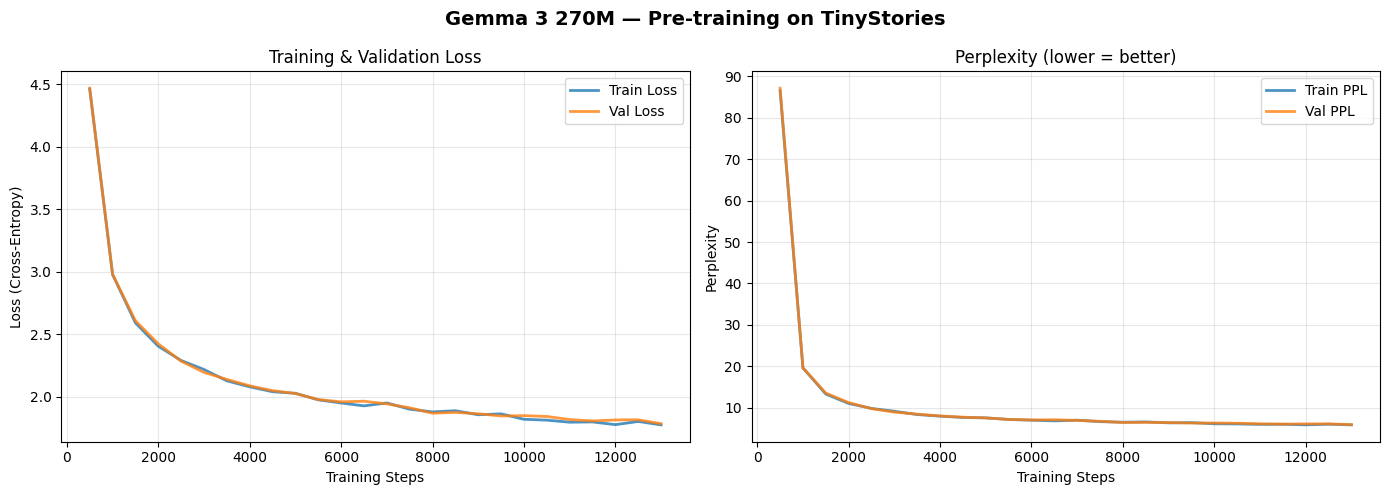

   📊 Saved: /content/drive/MyDrive/Gemma3_270M_Project/results/loss_curves.png

  🏁 TRAINING COMPLETE!
  ─────────────────────────────────────
  Model:          Gemma 3 270M (164.6M params)
  Dataset:        TinyStories (471M tokens)
  Best iteration: 13,000
  Best val loss:  1.7845
  Perplexity:     5.96
  ─────────────────────────────────────
  🧠 Ready for inference!


In [16]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 13: Load Best Model + Evaluate + Plot Curves                      ║
# ╚══════════════════════════════════════════════════════════════════════════╝

import math

# ── Load best checkpoint ──
print("📂 Loading best checkpoint...")
ckpt = torch.load(str(MODEL_DIR / "best_model.pt"), map_location=device, weights_only=False)
model.load_state_dict(ckpt['model_state_dict'])

best_iter = ckpt['iter']
best_val = ckpt['best_val_loss']
train_losses = ckpt.get('train_losses', [])
val_losses = ckpt.get('val_losses', [])
val_steps_log = ckpt.get('val_steps_log', [])

print(f"   ✅ Best model from iteration: {best_iter:,}")
print(f"   ✅ Best val loss:  {best_val:.4f}")
print(f"   ✅ Perplexity:     {math.exp(best_val):.2f}")

# ── Final evaluation ──
print(f"\n📊 Final Evaluation:")
final_losses = estimate_loss(model)
print(f"   Train loss: {final_losses['train']:.4f}  (perplexity: {math.exp(final_losses['train']):.2f})")
print(f"   Val loss:   {final_losses['val']:.4f}  (perplexity: {math.exp(final_losses['val']):.2f})")

# ── Plot loss curves ──
if len(val_losses) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    steps = val_steps_log[:len(train_losses)]
    axes[0].plot(steps, train_losses, label='Train Loss', alpha=0.8, linewidth=2)
    axes[0].plot(val_steps_log[:len(val_losses)], val_losses, label='Val Loss', alpha=0.8, linewidth=2)
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Loss (Cross-Entropy)')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Perplexity plot
    train_ppl = [math.exp(l) for l in train_losses]
    val_ppl = [math.exp(l) for l in val_losses]
    axes[1].plot(steps, train_ppl, label='Train PPL', alpha=0.8, linewidth=2, color='tab:blue')
    axes[1].plot(val_steps_log[:len(val_ppl)], val_ppl, label='Val PPL', alpha=0.8, linewidth=2, color='tab:orange')
    axes[1].set_xlabel('Training Steps')
    axes[1].set_ylabel('Perplexity')
    axes[1].set_title('Perplexity (lower = better)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    fig.suptitle('Gemma 3 270M — Pre-training on TinyStories', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / 'loss_curves.png'), dpi=150)
    plt.show()
    print(f"   📊 Saved: {RESULTS_DIR / 'loss_curves.png'}")

# ── Summary ──
print(f"\n{'='*55}")
print(f"  🏁 TRAINING COMPLETE!")
print(f"  ─────────────────────────────────────")
print(f"  Model:          Gemma 3 270M (164.6M params)")
print(f"  Dataset:        TinyStories (471M tokens)")
print(f"  Best iteration: {best_iter:,}")
print(f"  Best val loss:  {best_val:.4f}")
print(f"  Perplexity:     {math.exp(best_val):.2f}")
print(f"  ─────────────────────────────────────")
print(f"  🧠 Ready for inference!")
print(f"{'='*55}")

In [17]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 14: Story Generation & Inference                                  ║
# ║                                                                         ║
# ║  From your notes (page 22):                                             ║
# ║  Step 6: Inference                                                      ║
# ║  1. Get logits → Index of highest value → Token ID                     ║
# ║  2. Decode back to text                                                 ║
# ║  3. Appended to previous inputs → produce next token                   ║
# ║  4. Feed back to model → repeat                                        ║
# ╚══════════════════════════════════════════════════════════════════════════╝

model.eval()

def generate_story(
    prompt: str,
    max_tokens: int = 300,
    temperature: float = 0.8,
    top_k: int = 50,
    show_params: bool = True
) -> str:
    """Generate a story from a prompt."""
    if show_params:
        print(f"   🎛️  temperature={temperature}, top_k={top_k}, max_tokens={max_tokens}")

    input_ids = torch.tensor([enc.encode_ordinary(prompt)], device=device)

    with torch.no_grad(), autocast(device_type="cuda", dtype=dtype):
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_k=top_k,
        )

    return enc.decode(output_ids[0].tolist())


# ══════════════════════════════════════════════════════════════
# 📖 STORY GENERATION
# ══════════════════════════════════════════════════════════════

print("📖 Gemma 3 270M — Story Generation")
print("=" * 60)

prompts = [
    "Once upon a time, there was a little girl named Lily",
    "The big brown dog ran to the park",
    "Mom said it was time for bed, but Tommy",
    "One day, a magical bird flew into the garden",
    "The little boy was scared of the dark",
]

for i, prompt in enumerate(prompts, 1):
    print(f"\n{'─'*60}")
    print(f"  📝 Story {i}")
    print(f"{'─'*60}")
    print(f"   Prompt: \"{prompt}\"")
    story = generate_story(prompt, max_tokens=250, temperature=0.8, top_k=50)
    print(f"\n   {story}")

# ══════════════════════════════════════════════════════════════
# 🎛️ TEMPERATURE COMPARISON
# ══════════════════════════════════════════════════════════════

print(f"\n\n{'='*60}")
print("🌡️ Temperature Comparison (same prompt, different creativity)")
print("=" * 60)

test_prompt = "Once upon a time, there was a little cat"

for temp in [0.3, 0.7, 1.0]:
    label = {0.3: "Conservative (predictable)", 0.7: "Balanced", 1.0: "Creative (surprising)"}
    print(f"\n{'─'*60}")
    print(f"  🌡️ Temperature = {temp} — {label[temp]}")
    print(f"{'─'*60}")
    story = generate_story(test_prompt, max_tokens=150, temperature=temp, top_k=50)
    print(f"\n   {story}")

# ══════════════════════════════════════════════════════════════
# 📊 MODEL CARD SUMMARY
# ══════════════════════════════════════════════════════════════

print(f"\n\n{'='*60}")
print("📋 MODEL CARD — Gemma 3 270M (TinyStories)")
print("=" * 60)
print(f"""
   Architecture:     Gemma 3 (custom 270M variant)
   Parameters:       164.6M
   Context Length:    32,768 tokens
   Vocabulary:       50,257 (GPT-2 BPE tokenizer)
   Layers:           18 (15 sliding + 3 full attention)
   Embedding Dim:    640
   Attention Heads:  4 (Multi-Query, 1 KV group)
   Head Dimension:   256
   FFN Hidden:       2,048 (GeGLU activation)

   Training:
   ─────────────────────────────
   Dataset:          TinyStories (471M tokens)
   Best Iteration:   {best_iter:,}
   Best Val Loss:    {best_val:.4f}
   Perplexity:       {math.exp(best_val):.2f}
   Optimizer:        AdamW (β1=0.9, β2=0.95)
   Learning Rate:    1e-4 → 5e-5 (cosine decay)
   Precision:        bfloat16 mixed precision
   Hardware:         NVIDIA A100 40GB

   Key Features:
   ─────────────────────────────
   ✅ Sliding Window Attention (w=512)
   ✅ Multi-Query Attention (4:1 Q:KV ratio)
   ✅ RoPE with dual bases (10K local, 1M global)
   ✅ QK Normalization (RMSNorm)
   ✅ Gemma-style (1+weight) scaling in RMSNorm
   ✅ GeGLU Feed-Forward Network

   Credits: Vizuara Team - Raj
""")

print(f"{'='*60}")
print(f"  ✅ Cell 14 Done! Stories generated!")
print(f"{'='*60}")

📖 Gemma 3 270M — Story Generation

────────────────────────────────────────────────────────────
  📝 Story 1
────────────────────────────────────────────────────────────
   Prompt: "Once upon a time, there was a little girl named Lily"
   🎛️  temperature=0.8, top_k=50, max_tokens=250

   Once upon a time, there was a little girl named Lily. She loved to play with her toys and her friends. One day, Lily's mom bought her a new doll for her birthday. Lily was so happy and said, "Thank you, Mommy! I love my new doll." 

Lily's mom said, "I'm sorry, I was worried about your doll. I won't let you play with it again." Lily was so happy to have her favorite doll back. She played with it every day and couldn't wait to use it again. 

One day, Lily's mom told her that she couldn't touch her doll and that she had to leave it alone. Lily felt sad to leave her doll behind, but she knew it was time for a surprise. She opened her new doll, but there was nothing to see. She felt really sad but knew tha

In [22]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 15: Save Model & Push to HuggingFace Hub 🤗                      ║
# ║                                                                         ║
# ║  From your notes (page 22):                                             ║
# ║  "Save model to HuggingFace"                                           ║
# ╚══════════════════════════════════════════════════════════════════════════╝

!pip install huggingface_hub -q

from huggingface_hub import HfApi, login, create_repo
import json, shutil

# ── Step 1: Login to HuggingFace ──
print("🔑 Login to HuggingFace")
print("   Go to: https://huggingface.co/settings/tokens")
print("   Create a token with WRITE access")
print("   Paste it below:\n")
login()

# ── Step 2: Prepare model files ──
EXPORT_DIR = Path("/content/hf_export")
EXPORT_DIR.mkdir(exist_ok=True)

# Save model weights (PyTorch format)
print("\n📦 Preparing model files...")
torch.save(model.state_dict(), str(EXPORT_DIR / "pytorch_model.bin"))
print(f"   ✅ pytorch_model.bin ({(EXPORT_DIR / 'pytorch_model.bin').stat().st_size / 1e6:.1f} MB)")

# Save config
config_dict = {
    "architecture": "Gemma3Custom",
    "vocab_size": model_config.vocab_size,
    "context_length": model_config.context_length,
    "emb_dim": model_config.emb_dim,
    "n_layers": model_config.n_layers,
    "n_heads": model_config.n_heads,
    "head_dim": model_config.head_dim,
    "hidden_dim": model_config.hidden_dim,
    "n_kv_groups": model_config.n_kv_groups,
    "qk_norm": model_config.qk_norm,
    "query_pre_attn_scalar": model_config.query_pre_attn_scalar,
    "rope_base": model_config.rope_base,
    "rope_local_base": model_config.rope_local_base,
    "sliding_window": model_config.sliding_window,
    "dtype": "bfloat16",
    "total_parameters": sum(p.numel() for p in model.parameters()),
}

with open(EXPORT_DIR / "config.json", "w") as f:
    json.dump(config_dict, f, indent=2)
print("   ✅ config.json")

# Save training config
train_dict = {
    "max_iters": train_config.max_iters,
    "batch_size": train_config.batch_size,
    "block_size": train_config.block_size,
    "gradient_accumulation_steps": train_config.gradient_accumulation_steps,
    "learning_rate": train_config.learning_rate,
    "min_lr": train_config.min_lr,
    "warmup_steps": train_config.warmup_steps,
    "beta1": train_config.beta1,
    "beta2": train_config.beta2,
    "weight_decay": train_config.weight_decay,
    "gradient_clip_norm": train_config.gradient_clip_norm,
    "best_val_loss": best_val,
    "best_iteration": best_iter,
    "perplexity": round(math.exp(best_val), 2),
    "dataset": "roneneldan/TinyStories",
    "tokenizer": "gpt2 (tiktoken)",
    "hardware": "NVIDIA A100 40GB",
}

with open(EXPORT_DIR / "training_config.json", "w") as f:
    json.dump(train_dict, f, indent=2)
print("   ✅ training_config.json")

# Save layer types
with open(EXPORT_DIR / "layer_types.json", "w") as f:
    json.dump({"layer_types": model_config.layer_types}, f, indent=2)
print("   ✅ layer_types.json")

# Copy loss curves
if (RESULTS_DIR / 'loss_curves.png').exists():
    shutil.copy(RESULTS_DIR / 'loss_curves.png', EXPORT_DIR / 'loss_curves.png')
    print("   ✅ loss_curves.png")

if (RESULTS_DIR / 'lr_schedule.png').exists():
    shutil.copy(RESULTS_DIR / 'lr_schedule.png', EXPORT_DIR / 'lr_schedule.png')
    print("   ✅ lr_schedule.png")

# ── Step 3: Create Model Card (README.md) ──
model_card = f"""---
license: apache-2.0
tags:
  - gemma3
  - language-model
  - pre-training
  - from-scratch
  - tinystories
  - transformer
  - multi-query-attention
  - sliding-window-attention
  - rope
language:
  - en
datasets:
  - roneneldan/TinyStories
metrics:
  - perplexity
pipeline_tag: text-generation
---

# Gemma 3 270M — Pre-trained from Scratch on TinyStories

A custom implementation of the **Gemma 3 architecture** (scaled to 164.6M parameters), pre-trained from scratch on the TinyStories dataset.

## 📊 Results

| Metric | Value |
|--------|-------|
| **Best Val Loss** | {best_val:.4f} |
| **Perplexity** | {math.exp(best_val):.2f} |
| **Best Iteration** | {best_iter:,} |
| **Parameters** | 164.6M |

![Training Loss Curves](loss_curves.png)

## 🏗️ Architecture

This model implements the **complete Gemma 3 architecture** with all modern innovations:

| Component | Specification |
|-----------|--------------|
| Layers | 18 (15 sliding + 3 full attention) |
| Embedding Dim | 640 |
| Attention Heads | 4 (Multi-Query, 1 KV group) |
| Head Dimension | 256 |
| FFN Hidden | 2,048 (GeGLU activation) |
| Context Length | 32,768 tokens |
| Vocabulary | 50,257 (GPT-2 BPE) |

### Key Features
- **Sliding Window Attention** (w=512): O(n×w) instead of O(n²), 64× cheaper
- **Multi-Query Attention**: All query heads share 1 K,V head — 4× less KV cache
- **RoPE with Dual Bases**: 10K (local patterns) + 1M (long-range dependencies)
- **QK Normalization**: RMSNorm on Q,K vectors before attention
- **Gemma-style RMSNorm**: (1 + weight) scaling for stable initialization
- **GeGLU Feed-Forward**: Gated GELU activation with 3.2× expansion

### Layer Type Pattern
```
Layers 1-5:   Sliding Attention (local, base=10K)
Layer 6:      Full Attention (global, base=1M)
Layers 7-11:  Sliding Attention (local, base=10K)
Layer 12:     Full Attention (global, base=1M)
Layers 13-17: Sliding Attention (local, base=10K)
Layer 18:     Full Attention (global, base=1M)
```

## 📖 Training

- **Dataset**: TinyStories (2.1M stories, 471M tokens)
- **Tokenizer**: GPT-2 BPE via tiktoken (50,257 vocab)
- **Optimizer**: AdamW (β1=0.9, β2=0.95, ε=1e-9, weight_decay=0.1)
- **Learning Rate**: 1e-4 → 5e-5 (cosine decay with 1K step warmup)
- **Precision**: bfloat16 mixed precision
- **Hardware**: NVIDIA A100 40GB (Google Colab Pro)
- **Gradient Clipping**: max_norm=0.5

## 💻 Usage
```python
import torch
import tiktoken

# Load model (you'll need the model class definition)
model = Gemma3Model(config)
state_dict = torch.load("pytorch_model.bin", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# Tokenize
enc = tiktoken.get_encoding("gpt2")
prompt = "Once upon a time"
input_ids = torch.tensor([enc.encode_ordinary(prompt)])

# Generate
with torch.no_grad():
    output = model.generate(input_ids, max_new_tokens=200, temperature=0.7)
print(enc.decode(output[0].tolist()))
```

## 📝 Sample Outputs

**Prompt**: "Once upon a time, there was a little cat named Mittens"

**Temperature 0.7**: *Mittens was very hungry and wanted to eat some food. She went outside
to find some grass to eat. Mittens saw a big tree and decided to climb it. She climbed up and
up until she reached the top. As she was in the tree, she saw a small bird with a broken wing.
Mittens knew just what to do. She took the bird to her mom and asked for help.*

## 🙏 Credits

- **Architecture Reference**: Vizuara Team - Raj ([Tutorial](https://youtu.be/bLDlwcl6hbA))
- **Dataset**: TinyStories by Ronen Eldan & Yuanzhi Li
- **Tokenizer**: OpenAI tiktoken (GPT-2 BPE)

## 📄 License

Apache 2.0
"""

with open(EXPORT_DIR / "README.md", "w") as f:
    f.write(model_card)
print("   ✅ README.md (model card)")

# ── Step 4: Upload to HuggingFace Hub ──
print(f"\n🚀 Uploading to HuggingFace Hub...")

# CHANGE THIS to your HuggingFace username!
HF_USERNAME = input("Enter your HuggingFace username: ").strip()
REPO_NAME = f"{HF_USERNAME}/gemma3-270m-tinystories"

api = HfApi()

# Create repo
try:
    create_repo(REPO_NAME, repo_type="model", exist_ok=True)
    print(f"   ✅ Repo created: https://huggingface.co/{REPO_NAME}")
except Exception as e:
    print(f"   ℹ️  Repo may already exist: {e}")

# Upload all files
api.upload_folder(
    folder_path=str(EXPORT_DIR),
    repo_id=REPO_NAME,
    repo_type="model",
)

print(f"\n{'='*60}")
print(f"  🎉 MODEL UPLOADED TO HUGGINGFACE!")
print(f"  🔗 https://huggingface.co/{REPO_NAME}")
print(f"{'='*60}")

🔑 Login to HuggingFace
   Go to: https://huggingface.co/settings/tokens
   Create a token with WRITE access
   Paste it below:


📦 Preparing model files...
   ✅ pytorch_model.bin (329.3 MB)
   ✅ config.json
   ✅ training_config.json
   ✅ layer_types.json
   ✅ loss_curves.png
   ✅ lr_schedule.png
   ✅ README.md (model card)

🚀 Uploading to HuggingFace Hub...
Enter your HuggingFace username: G3nadh
   ✅ Repo created: https://huggingface.co/G3nadh/gemma3-270m-tinystories


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._export/pytorch_model.bin:   0%|          |  612kB /  329MB            

  ...hf_export/loss_curves.png:   2%|1         | 1.72kB /  103kB            


  🎉 MODEL UPLOADED TO HUGGINGFACE!
  🔗 https://huggingface.co/G3nadh/gemma3-270m-tinystories


In [24]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 15: Generate ALL Visual Assets for Blog & README                  ║
# ║                                                                         ║
# ║  This cell creates 12+ publication-quality visualizations:              ║
# ║  1.  Parameter breakdown (pie + bar chart)                              ║
# ║  2.  Layer types pattern (sliding vs full attention)                    ║
# ║  3.  MQA vs Standard attention comparison                              ║
# ║  4.  Sliding window vs full attention masking                           ║
# ║  5.  RoPE dual-base frequency visualization                            ║
# ║  6.  Training loss curves (enhanced)                                    ║
# ║  7.  Learning rate schedule                                             ║
# ║  8.  Model size comparison (us vs industry)                             ║
# ║  9.  Token frequency distribution                                       ║
# ║  10. Perplexity over training                                           ║
# ║  11. Temperature effect on generation                                   ║
# ║  12. Architecture overview (full pipeline)                              ║
# ║  13. Memory usage breakdown                                             ║
# ║  14. Dataset statistics                                                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝



In [28]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 15: Generate ALL Visual Assets for Blog & README                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝

import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from pathlib import Path

VIS_DIR = Path("/content/drive/MyDrive/Gemma3_270M_Project/results/visuals")
VIS_DIR.mkdir(parents=True, exist_ok=True)
saved = []

def save(fig, name):
    path = VIS_DIR / name
    fig.savefig(path, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close(fig)
    saved.append(name)
    print(f"   ✅ {name}")

print("🎨 Generating Visual Assets...")
print("=" * 60)


# ══════════════════════════════════════════════════════════════
# 1. PARAMETER BREAKDOWN
# ══════════════════════════════════════════════════════════════
print("\n📊 1. Parameter Breakdown")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Gemma 3 270M — Parameter Distribution (164.6M total)", fontsize=16, fontweight='bold', y=1.02)

components = ['Embedding\n(50,257×640)', 'Attention\n(18 layers)', 'FFN\n(18 layers)', 'Norms + Output\nProjection']
params = [32_164_480, 29_489_472, 70_778_880, 32_199_104]
colors = ['#4CAF50', '#7B1FA2', '#00838F', '#FF9800']
explode = (0.03, 0.03, 0.08, 0.03)

wedges, texts, autotexts = ax1.pie(params, labels=components, colors=colors, autopct='%1.1f%%',
    startangle=90, explode=explode, textprops={'fontsize': 10})
for t in autotexts:
    t.set_fontweight('bold')
    t.set_fontsize(11)
ax1.set_title("Where Do The Parameters Live?", fontsize=13, fontweight='bold', pad=15)

layer_components = ['embed_tokens\n(50,257→640)', 'attn.q_proj\n×18 layers', 'attn.k_proj\n×18 layers',
    'attn.v_proj\n×18 layers', 'attn.o_proj\n×18 layers', 'ffn.gate_proj\n×18 layers',
    'ffn.up_proj\n×18 layers', 'ffn.down_proj\n×18 layers', 'norms\n(37 total)', 'output_proj\n(640→50,257)']
layer_params = [32_164_480, 11_796_480, 2_949_120, 2_949_120, 11_796_480,
    23_592_960, 23_592_960, 23_592_960, 24_320, 32_164_480]
layer_colors = ['#4CAF50', '#9C27B0', '#AB47BC', '#CE93D8', '#7B1FA2',
    '#006064', '#00838F', '#4DD0E1', '#FFB74D', '#FF9800']

bars = ax2.barh(range(len(layer_components)), [p/1e6 for p in layer_params], color=layer_colors)
ax2.set_yticks(range(len(layer_components)))
ax2.set_yticklabels(layer_components, fontsize=9)
ax2.set_xlabel("Parameters (millions)", fontsize=11)
ax2.set_title("Parameters per Component", fontsize=13, fontweight='bold')
ax2.invert_yaxis()

for bar, p in zip(bars, layer_params):
    ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, f'{p/1e6:.1f}M', va='center', fontsize=9)

plt.tight_layout()
save(fig, "01_parameter_breakdown.png")


# ══════════════════════════════════════════════════════════════
# 2. LAYER TYPES PATTERN
# ══════════════════════════════════════════════════════════════
print("📊 2. Layer Types Pattern")

fig, ax = plt.subplots(figsize=(14, 4))
fig.suptitle("18-Layer Architecture — Sliding vs Full Attention Pattern", fontsize=16, fontweight='bold')

layer_types = model_config.layer_types
colors_map = {'sliding_attention': '#42A5F5', 'full_attention': '#FF6F00'}

for i, lt in enumerate(layer_types):
    rect = FancyBboxPatch((i * 0.95, 0.1), 0.85, 0.8,
        boxstyle="round,pad=0.05", facecolor=colors_map[lt], edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    ax.text(i * 0.95 + 0.425, 0.5, f"L{i+1}", ha='center', va='center',
        fontsize=10, fontweight='bold', color='white')
    label = "S" if lt == "sliding_attention" else "F"
    ax.text(i * 0.95 + 0.425, 0.2, label, ha='center', va='center',
        fontsize=8, color=(1, 1, 1, 0.7))

for i, lt in enumerate(layer_types):
    base = "10K" if lt == "sliding_attention" else "1M"
    color = '#1976D2' if lt == "sliding_attention" else '#E65100'
    ax.text(i * 0.95 + 0.425, -0.15, base, ha='center', va='center', fontsize=8, color=color, fontweight='bold')

ax.text(8.5, -0.35, "RoPE Base →", ha='center', fontsize=10, style='italic', color='#555')

sliding_patch = mpatches.Patch(color='#42A5F5', label='Sliding Attention (local, window=512, RoPE base=10K)')
full_patch = mpatches.Patch(color='#FF6F00', label='Full Attention (global, no window limit, RoPE base=1M)')
ax.legend(handles=[sliding_patch, full_patch], loc='upper center', ncol=2, fontsize=10,
    bbox_to_anchor=(0.5, 1.25), frameon=True, fancybox=True, shadow=True)

ax.set_xlim(-0.2, 17.5)
ax.set_ylim(-0.5, 1.1)
ax.axis('off')
plt.tight_layout()
save(fig, "02_layer_types_pattern.png")


# ══════════════════════════════════════════════════════════════
# 3. MQA vs STANDARD ATTENTION
# ══════════════════════════════════════════════════════════════
print("📊 3. MQA vs Standard Attention")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Multi-Query Attention vs Standard Multi-Head Attention", fontsize=16, fontweight='bold', y=1.02)

ax1.set_title("❌ Standard Multi-Head\n(4× more KV cache)", fontsize=13, fontweight='bold', color='#C62828')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')

for i in range(4):
    rect = FancyBboxPatch((0.5 + i*2.2, 7), 1.8, 1.2, boxstyle="round,pad=0.1",
        facecolor='#1565C0', edgecolor='white', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(1.4 + i*2.2, 7.6, f"Q{i+1}", ha='center', va='center', color='white', fontweight='bold', fontsize=12)

for i in range(4):
    rect = FancyBboxPatch((0.5 + i*2.2, 4.5), 1.8, 1.2, boxstyle="round,pad=0.1",
        facecolor='#C62828', edgecolor='white', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(1.4 + i*2.2, 5.1, f"K{i+1}", ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    ax1.annotate('', xy=(1.4+i*2.2, 6.95), xytext=(1.4+i*2.2, 5.75),
        arrowprops=dict(arrowstyle='->', color='#C62828', lw=1.5))

for i in range(4):
    rect = FancyBboxPatch((0.5 + i*2.2, 2), 1.8, 1.2, boxstyle="round,pad=0.1",
        facecolor='#2E7D32', edgecolor='white', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(1.4 + i*2.2, 2.6, f"V{i+1}", ha='center', va='center', color='white', fontweight='bold', fontsize=12)

rect = FancyBboxPatch((1, 0.2), 7.5, 1.2, boxstyle="round,pad=0.1", facecolor='#FFCDD2', edgecolor='#C62828', linewidth=2)
ax1.add_patch(rect)
ax1.text(4.75, 0.8, "KV Cache: 4 × 256 = 1,024 dims", ha='center', va='center', fontsize=12, fontweight='bold', color='#C62828')

ax2.set_title("✅ Multi-Query (Gemma 3)\n(4× cheaper KV cache!)", fontsize=13, fontweight='bold', color='#2E7D32')
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')

for i in range(4):
    rect = FancyBboxPatch((0.5 + i*2.2, 7), 1.8, 1.2, boxstyle="round,pad=0.1",
        facecolor='#1565C0', edgecolor='white', linewidth=2)
    ax2.add_patch(rect)
    ax2.text(1.4 + i*2.2, 7.6, f"Q{i+1}", ha='center', va='center', color='white', fontweight='bold', fontsize=12)

rect = FancyBboxPatch((2.5, 4.5), 5, 1.2, boxstyle="round,pad=0.1", facecolor='#C62828', edgecolor='white', linewidth=2)
ax2.add_patch(rect)
ax2.text(5, 5.1, "1 Shared K Head", ha='center', va='center', color='white', fontweight='bold', fontsize=13)

for i in range(4):
    ax2.annotate('', xy=(1.4+i*2.2, 6.95), xytext=(3.5+i*0.9, 5.75),
        arrowprops=dict(arrowstyle='->', color='#C62828', lw=1.5, ls='--'))

rect = FancyBboxPatch((2.5, 2), 5, 1.2, boxstyle="round,pad=0.1", facecolor='#2E7D32', edgecolor='white', linewidth=2)
ax2.add_patch(rect)
ax2.text(5, 2.6, "1 Shared V Head", ha='center', va='center', color='white', fontweight='bold', fontsize=13)

rect = FancyBboxPatch((1, 0.2), 7.5, 1.2, boxstyle="round,pad=0.1", facecolor='#C8E6C9', edgecolor='#2E7D32', linewidth=2)
ax2.add_patch(rect)
ax2.text(4.75, 0.8, "KV Cache: 1 × 256 = 256 dims  (4× cheaper!)", ha='center', va='center', fontsize=12, fontweight='bold', color='#2E7D32')

plt.tight_layout()
save(fig, "03_mqa_vs_standard.png")


# ══════════════════════════════════════════════════════════════
# 4. SLIDING WINDOW vs FULL ATTENTION MASKS
# ══════════════════════════════════════════════════════════════
print("📊 4. Sliding Window vs Full Attention Masks")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Attention Masking — What Each Token Can See", fontsize=16, fontweight='bold', y=1.02)

seq_len = 16

causal = np.tril(np.ones((seq_len, seq_len)))
ax1.imshow(causal, cmap='Blues', aspect='equal')
ax1.set_title("Basic Causal Mask\n(standard transformer)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Key position (past)")
ax1.set_ylabel("Query position (current)")
ax1.set_xticks(range(0, seq_len, 4))
ax1.set_yticks(range(0, seq_len, 4))

window = 4
sliding = np.zeros((seq_len, seq_len))
for i in range(seq_len):
    for j in range(seq_len):
        if j <= i and i - j <= window:
            sliding[i][j] = 1.0
ax2.imshow(sliding, cmap='Purples', aspect='equal')
ax2.set_title(f"Sliding Window (w={window})\n(15 of 18 layers — LOCAL)", fontsize=12, fontweight='bold', color='#7B1FA2')
ax2.set_xlabel("Key position")
ax2.set_ylabel("Query position")
ax2.set_xticks(range(0, seq_len, 4))
ax2.set_yticks(range(0, seq_len, 4))

ax3.imshow(causal, cmap='Oranges', aspect='equal')
ax3.set_title("Full Causal Attention\n(3 of 18 layers — GLOBAL)", fontsize=12, fontweight='bold', color='#E65100')
ax3.set_xlabel("Key position")
ax3.set_ylabel("Query position")
ax3.set_xticks(range(0, seq_len, 4))
ax3.set_yticks(range(0, seq_len, 4))

ax1.text(8, -2.5, "O(n²) — sees everything before it", ha='center', fontsize=10, style='italic', color='#1565C0')
ax2.text(8, -2.5, f"O(n×w) — only sees last {window} tokens (64× cheaper!)", ha='center', fontsize=10, style='italic', color='#7B1FA2')
ax3.text(8, -2.5, "O(n²) — full context for long-range dependencies", ha='center', fontsize=10, style='italic', color='#E65100')

plt.tight_layout()
save(fig, "04_attention_masks.png")


# ══════════════════════════════════════════════════════════════
# 5. RoPE DUAL-BASE FREQUENCIES
# ══════════════════════════════════════════════════════════════
print("📊 5. RoPE Dual-Base Frequencies")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("RoPE — Rotary Position Encoding with Dual Bases", fontsize=16, fontweight='bold', y=1.02)

head_dim = 256
positions = np.arange(512)

local_base = 10_000
i_vals = np.arange(0, head_dim, 2)
local_freqs = 1.0 / (local_base ** (i_vals / head_dim))

global_base = 1_000_000
global_freqs = 1.0 / (global_base ** (i_vals / head_dim))

ax = axes[0, 0]
ax.semilogy(i_vals, local_freqs, color='#1565C0', linewidth=2, label='Local base=10K')
ax.semilogy(i_vals, global_freqs, color='#E65100', linewidth=2, label='Global base=1M')
ax.set_xlabel("Dimension index (i)", fontsize=11)
ax.set_ylabel("Frequency (log scale)", fontsize=11)
ax.set_title("Frequency Decay per Dimension", fontsize=13, fontweight='bold')
ax.legend(fontsize=11, frameon=True, fancybox=True)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for dim_i in [0, 32, 64, 96]:
    freq_local = 1.0 / (local_base ** (dim_i / head_dim))
    angles = positions * freq_local
    ax.plot(positions, np.sin(angles), linewidth=1.5, label=f'dim {dim_i}', alpha=0.8)
ax.set_xlabel("Position in sequence", fontsize=11)
ax.set_ylabel("sin(θ)", fontsize=11)
ax.set_title("Local Base (10K) — Fast Rotations\n(Good for nearby tokens)", fontsize=13, fontweight='bold', color='#1565C0')
ax.legend(fontsize=9, frameon=True, loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
for dim_i in [0, 32, 64, 96]:
    freq_global = 1.0 / (global_base ** (dim_i / head_dim))
    angles = positions * freq_global
    ax.plot(positions, np.sin(angles), linewidth=1.5, label=f'dim {dim_i}', alpha=0.8)
ax.set_xlabel("Position in sequence", fontsize=11)
ax.set_ylabel("sin(θ)", fontsize=11)
ax.set_title("Global Base (1M) — Slow Rotations\n(Good for distant tokens)", fontsize=13, fontweight='bold', color='#E65100')
ax.legend(fontsize=9, frameon=True, loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.axis('off')
table_data = [
    ["Property", "Local (10K)", "Global (1M)"],
    ["Base frequency", "10,000", "1,000,000"],
    ["Rotation speed", "Fast", "Slow"],
    ["Best for", "Nearby tokens", "Distant tokens"],
    ["Used in layers", "1-5, 7-11, 13-17", "6, 12, 18"],
    ["Attention type", "Sliding window", "Full attention"],
    ["Layers count", "15 layers", "3 layers"],
    ["Analogy", "Hour hand", "Year hand"],
]
table = ax.table(cellText=table_data[1:], colLabels=table_data[0],
    cellLoc='center', loc='center', colColours=['#E3F2FD', '#E3F2FD', '#FFF3E0'])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.6)
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(11)
        cell.set_text_props(fontweight='bold')
    cell.set_edgecolor('#ddd')
ax.set_title("Dual-Base Summary", fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
save(fig, "05_rope_dual_base.png")


# ══════════════════════════════════════════════════════════════
# 6. ENHANCED TRAINING LOSS CURVES
# ══════════════════════════════════════════════════════════════
print("📊 6. Enhanced Training Loss Curves")

ckpt = torch.load(str("/content/drive/MyDrive/Gemma3_270M_Project/checkpoints/best_model.pt"), map_location="cpu", weights_only=False)
train_losses = ckpt.get('train_losses', [])
val_losses = ckpt.get('val_losses', [])

if train_losses and val_losses:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("Gemma 3 270M — Training Progress on TinyStories", fontsize=16, fontweight='bold', y=1.04)

    steps = list(range(len(train_losses)))
    eval_interval = 500
    x_steps = [i * eval_interval for i in steps]

    ax = axes[0]
    ax.plot(x_steps, train_losses, color='#1565C0', linewidth=2, label='Train Loss', alpha=0.9)
    ax.plot(x_steps, val_losses, color='#E65100', linewidth=2, label='Val Loss', alpha=0.9)
    best_idx = val_losses.index(min(val_losses))
    ax.scatter([x_steps[best_idx]], [val_losses[best_idx]], color='#E65100', s=100, zorder=5, marker='*')
    ax.annotate(f'Best: {min(val_losses):.4f}\n(step {x_steps[best_idx]:,})',
        xy=(x_steps[best_idx], val_losses[best_idx]), xytext=(x_steps[best_idx]+1000, val_losses[best_idx]+0.3),
        arrowprops=dict(arrowstyle='->', color='#E65100'), fontsize=10, fontweight='bold', color='#E65100')
    ax.set_xlabel("Training Steps", fontsize=11)
    ax.set_ylabel("Cross-Entropy Loss", fontsize=11)
    ax.set_title("Training & Validation Loss", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, frameon=True)
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    train_ppl = [math.exp(l) for l in train_losses]
    val_ppl = [math.exp(l) for l in val_losses]
    ax.plot(x_steps, train_ppl, color='#1565C0', linewidth=2, label='Train PPL', alpha=0.9)
    ax.plot(x_steps, val_ppl, color='#E65100', linewidth=2, label='Val PPL', alpha=0.9)
    ax.axhline(y=math.exp(min(val_losses)), color='#E65100', linestyle='--', alpha=0.5, label=f'Best: {math.exp(min(val_losses)):.2f}')
    ax.set_xlabel("Training Steps", fontsize=11)
    ax.set_ylabel("Perplexity (lower = better)", fontsize=11)
    ax.set_title("Perplexity Over Training", fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, frameon=True)
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    if len(val_losses) > 1:
        loss_delta = [val_losses[i] - val_losses[i-1] for i in range(1, len(val_losses))]
        ax.bar(range(len(loss_delta)), loss_delta,
            color=['#4CAF50' if d < 0 else '#F44336' for d in loss_delta], alpha=0.8)
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_xlabel("Evaluation Step", fontsize=11)
        ax.set_ylabel("Val Loss Change (delta)", fontsize=11)
        ax.set_title("Learning Progress\n(green=improving, red=overfitting)", fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    save(fig, "06_training_curves.png")
else:
    print("   ⚠️  No training logs in checkpoint, skipping")


# ══════════════════════════════════════════════════════════════
# 7. LEARNING RATE SCHEDULE
# ══════════════════════════════════════════════════════════════
print("📊 7. Learning Rate Schedule")

fig, ax = plt.subplots(figsize=(12, 5))
steps_range = np.arange(0, 60001)
lrs = []
for step in steps_range:
    if step < 1000:
        lr = 1e-4 * step / 1000
    elif step < 60000:
        progress = (step - 1000) / (60000 - 1000)
        lr = 5e-5 + 0.5 * (1e-4 - 5e-5) * (1 + math.cos(math.pi * progress))
    else:
        lr = 5e-5
    lrs.append(lr)

ax.plot(steps_range, lrs, color='#1565C0', linewidth=2.5)
ax.fill_between(steps_range[:1000], 0, lrs[:1000], alpha=0.15, color='#4CAF50', label='Warmup (0-1K)')
ax.fill_between(steps_range[1000:60000], 0, lrs[1000:60000], alpha=0.1, color='#1565C0', label='Cosine Decay (1K-60K)')
ax.fill_between(steps_range[60000:], 0, lrs[60000:], alpha=0.15, color='#FF9800', label='Min LR (60K+)')

ax.axvline(x=best_iter, color='#E65100', linestyle='--', linewidth=2, alpha=0.7, label=f'Best model (step {best_iter:,})')

ax.set_xlabel("Training Steps", fontsize=12)
ax.set_ylabel("Learning Rate", fontsize=12)
ax.set_title("Cosine Learning Rate Schedule with Linear Warmup", fontsize=14, fontweight='bold')
ax.legend(fontsize=11, frameon=True, fancybox=True)
ax.grid(True, alpha=0.3)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-4,-4))

save(fig, "07_lr_schedule.png")


# ══════════════════════════════════════════════════════════════
# 8. MODEL SIZE COMPARISON
# ══════════════════════════════════════════════════════════════
print("📊 8. Model Size Comparison")

fig, ax = plt.subplots(figsize=(14, 6))

models = ['Our Gemma 3\n(164M)', 'GPT-2\nSmall', 'GPT-2\nMedium', 'GPT-2\nLarge', 'GPT-2\nXL',
    'Llama 3.2\n1B', 'Llama 3.2\n3B', 'Llama 3.1\n8B', 'Llama 3.1\n70B', 'GPT-4\n(estimated)']
sizes = [0.165, 0.124, 0.355, 0.774, 1.558, 1.0, 3.0, 8.0, 70.0, 1000.0]
bar_colors = ['#E65100'] + ['#90CAF9']*4 + ['#66BB6A']*4 + ['#CE93D8']

bars = ax.barh(range(len(models)), sizes, color=bar_colors, edgecolor='white', linewidth=1.5)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models, fontsize=10)
ax.set_xlabel("Parameters (Billions)", fontsize=12)
ax.set_title("Model Size Comparison — Where Does Our Model Fit?", fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.invert_yaxis()

for bar, size in zip(bars, sizes):
    label = f"{size:.3f}B" if size < 1 else f"{size:.0f}B"
    ax.text(bar.get_width() * 1.2, bar.get_y() + bar.get_height()/2, label, va='center', fontsize=10, fontweight='bold')

bars[0].set_edgecolor('#E65100')
bars[0].set_linewidth(3)

ax.annotate('YOU ARE HERE\n(built from scratch!)',
    xy=(0.165, 0), fontsize=11, fontweight='bold', color='#E65100',
    xytext=(3, 0.5), arrowprops=dict(arrowstyle='->', color='#E65100', lw=2))

ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
save(fig, "08_model_size_comparison.png")


# ══════════════════════════════════════════════════════════════
# 9. DATASET STATISTICS
# ══════════════════════════════════════════════════════════════
print("📊 9. Dataset Statistics")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("TinyStories Dataset — 2.1 Million Children's Stories", fontsize=16, fontweight='bold', y=1.04)

ax = axes[0]
categories = ['Train\nTokens', 'Val\nTokens']
token_counts = [471_000_000, 4_700_000]
bars = ax.bar(categories, [t/1e6 for t in token_counts], color=['#1565C0', '#E65100'], width=0.6)
ax.set_ylabel("Tokens (Millions)", fontsize=11)
ax.set_title("Token Count", fontsize=13, fontweight='bold')
for bar, count in zip(bars, token_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{count/1e6:.0f}M',
        ha='center', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1]
vocab_cats = ['Total\nVocab', 'Commonly\nUsed', 'Rare\n(<10 times)']
vocab_counts = [50257, 12000, 30000]
vc_colors = ['#42A5F5', '#4CAF50', '#FF9800']
bars = ax.bar(vocab_cats, [v/1000 for v in vocab_counts], color=vc_colors, width=0.6)
ax.set_ylabel("Tokens (Thousands)", fontsize=11)
ax.set_title("Vocabulary Distribution", fontsize=13, fontweight='bold')
for bar, count in zip(bars, vocab_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{count/1000:.0f}K',
        ha='center', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

ax = axes[2]
ax.axis('off')
config_data = [
    ["Setting", "Value"],
    ["Batch Size", "32 sequences"],
    ["Sequence Length", "512 tokens"],
    ["Grad Accumulation", "4 steps"],
    ["Effective Batch", "128 seq = 65,536 tok"],
    ["Optimizer", "AdamW"],
    ["Peak LR", "1e-4"],
    ["Min LR", "5e-5"],
    ["Weight Decay", "0.1"],
    ["Grad Clip", "0.5"],
    ["Precision", "bfloat16"],
]
table = ax.table(cellText=config_data[1:], colLabels=config_data[0],
    cellLoc='center', loc='center', colColours=['#E3F2FD', '#E3F2FD'])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(11)
        cell.set_text_props(fontweight='bold')
    cell.set_edgecolor('#ddd')
ax.set_title("Training Configuration", fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
save(fig, "09_dataset_statistics.png")


# ══════════════════════════════════════════════════════════════
# 10. GeGLU FFN ARCHITECTURE
# ══════════════════════════════════════════════════════════════
print("📊 10. GeGLU FFN Architecture")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Feed-Forward Network — GeGLU (Gated GELU) Architecture", fontsize=16, fontweight='bold', y=1.02)

ax1.axis('off')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)

rect = FancyBboxPatch((3.5, 8.5), 3, 0.8, boxstyle="round,pad=0.1", facecolor='#E3F2FD', edgecolor='#1565C0', linewidth=2)
ax1.add_patch(rect)
ax1.text(5, 8.9, "Input (640 dim)", ha='center', va='center', fontsize=12, fontweight='bold', color='#1565C0')

rect = FancyBboxPatch((0.5, 6.2), 3.5, 1.2, boxstyle="round,pad=0.1", facecolor='#7B1FA2', edgecolor='white', linewidth=2)
ax1.add_patch(rect)
ax1.text(2.25, 6.8, "gate_proj\n640 -> 2048", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

rect = FancyBboxPatch((5.5, 6.2), 3.5, 1.2, boxstyle="round,pad=0.1", facecolor='#00838F', edgecolor='white', linewidth=2)
ax1.add_patch(rect)
ax1.text(7.25, 6.8, "up_proj\n640 -> 2048", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

rect = FancyBboxPatch((0.5, 4.5), 3.5, 0.8, boxstyle="round,pad=0.1", facecolor='#FF9800', edgecolor='white', linewidth=2)
ax1.add_patch(rect)
ax1.text(2.25, 4.9, "GELU activation", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

ax1.add_patch(plt.Circle((5, 4.9), 0.4, facecolor='#F44336', edgecolor='white', linewidth=2))
ax1.text(5, 4.9, "x", ha='center', va='center', fontsize=18, fontweight='bold', color='white')

rect = FancyBboxPatch((3, 2.2), 4, 1, boxstyle="round,pad=0.1", facecolor='#1565C0', edgecolor='white', linewidth=2)
ax1.add_patch(rect)
ax1.text(5, 2.7, "down_proj\n2048 -> 640", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

rect = FancyBboxPatch((3.5, 0.5), 3, 0.8, boxstyle="round,pad=0.1", facecolor='#E3F2FD', edgecolor='#1565C0', linewidth=2)
ax1.add_patch(rect)
ax1.text(5, 0.9, "Output (640 dim)", ha='center', va='center', fontsize=12, fontweight='bold', color='#1565C0')

for start, end in [((5, 8.5), (2.25, 7.45)), ((5, 8.5), (7.25, 7.45)),
    ((2.25, 6.2), (2.25, 5.35)), ((2.25, 4.5), (4.65, 4.9)), ((7.25, 6.2), (5.35, 4.9)),
    ((5, 4.45), (5, 3.25)), ((5, 2.2), (5, 1.35))]:
    ax1.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->', color='#555', lw=1.5))

ax1.set_title("GeGLU Architecture", fontsize=13, fontweight='bold')

ax2.set_title("GELU vs ReLU Activation Functions", fontsize=13, fontweight='bold')
x = np.linspace(-4, 4, 1000)
gelu = 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))
relu = np.maximum(0, x)

ax2.plot(x, gelu, color='#FF9800', linewidth=2.5, label='GELU (Gemma 3 uses this)')
ax2.plot(x, relu, color='#90CAF9', linewidth=2, linestyle='--', label='ReLU (older models)')
ax2.axhline(y=0, color='gray', linewidth=0.5)
ax2.axvline(x=0, color='gray', linewidth=0.5)
ax2.set_xlabel("Input", fontsize=11)
ax2.set_ylabel("Output", fontsize=11)
ax2.legend(fontsize=11, frameon=True, fancybox=True)
ax2.grid(True, alpha=0.3)
ax2.annotate("Smooth curve\n(better gradients!)", xy=(-1, -0.17), fontsize=10, color='#FF9800',
    xytext=(-3, -1.5), arrowprops=dict(arrowstyle='->', color='#FF9800'))

plt.tight_layout()
save(fig, "10_geglu_ffn.png")


# ══════════════════════════════════════════════════════════════
# 11. RMSNorm VISUALIZATION
# ══════════════════════════════════════════════════════════════
print("📊 11. RMSNorm Visualization")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("RMSNorm — Gemma 3's (1 + weight) Scaling Innovation", fontsize=16, fontweight='bold', y=1.04)

ax1.axis('off')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_title("Step-by-Step Example: x = [2, -6]", fontsize=13, fontweight='bold')

steps_info = [
    ("Step 1: Variance", "var(x) = (4 + 36)/2 = 20", 8.5, '#42A5F5'),
    ("Step 2: RMS", "rms(x) = sqrt(20 + eps) = 4.472", 7.0, '#66BB6A'),
    ("Step 3: Normalize", "x_hat = [2/4.472, -6/4.472] = [0.447, -1.342]", 5.5, '#FF9800'),
    ("Step 4: Scale", "y = x_hat * (1 + weight)", 4.0, '#E91E63'),
    ("Step 5: Result", "weights=0.5 -> y = [0.447*1.5, -1.342*1.5]", 2.5, '#7B1FA2'),
    ("", "= [0.671, -2.013]", 1.5, '#7B1FA2'),
]

for label, formula, y_pos, color in steps_info:
    if label:
        ax1.text(0.5, y_pos, label, fontsize=11, fontweight='bold', color=color)
    ax1.text(0.5, y_pos - 0.6, formula, fontsize=10, color='#333', family='monospace')

ax2.set_title("Why (1 + weight) Is Better", fontsize=13, fontweight='bold')
x_range = np.linspace(-3, 3, 100)

ax2.plot(x_range, 1.0 * x_range, color='#90CAF9', linewidth=2, linestyle='--',
    label='Standard: weight * x\n(weight init=1, can drift)')
ax2.plot(x_range, (1 + 0.0) * x_range, color='#4CAF50', linewidth=2.5,
    label='Gemma: (1+0) * x = identity\n(stable start, gradual learning)')
ax2.plot(x_range, (1 + 0.5) * x_range, color='#FF9800', linewidth=1.5, alpha=0.7,
    label='After training: (1+0.5) * x')

ax2.axhline(y=0, color='gray', linewidth=0.5)
ax2.axvline(x=0, color='gray', linewidth=0.5)
ax2.set_xlabel("Normalized Input", fontsize=11)
ax2.set_ylabel("Scaled Output", fontsize=11)
ax2.legend(fontsize=10, frameon=True, fancybox=True, loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
save(fig, "11_rmsnorm.png")


# ══════════════════════════════════════════════════════════════
# 12. TEMPERATURE EFFECT
# ══════════════════════════════════════════════════════════════
print("📊 12. Temperature Effect on Sampling")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Temperature Controls Creativity — Probability Distribution for Next Word",
    fontsize=16, fontweight='bold', y=1.04)

words = ['mat', 'floor', 'couch', 'bed', 'rug', 'table', 'chair', 'wall', 'roof', 'door']
raw_logits = np.array([3.5, 2.8, 2.1, 1.8, 1.5, 1.0, 0.7, 0.3, -0.2, -0.8])

for ax, temp, title, color in [
    (axes[0], 0.3, "Temperature = 0.3\n(Conservative)", '#1565C0'),
    (axes[1], 0.7, "Temperature = 0.7\n(Balanced)", '#4CAF50'),
    (axes[2], 1.0, "Temperature = 1.0\n(Creative)", '#E65100'),
]:
    logits = raw_logits / temp
    probs = np.exp(logits) / np.exp(logits).sum()

    bars = ax.bar(range(len(words)), probs * 100, color=color, alpha=0.8, edgecolor='white')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel("Probability (%)", fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold', color=color)
    ax.set_ylim(0, max(probs*100) * 1.2)
    ax.grid(True, alpha=0.3, axis='y')

    top_idx = np.argmax(probs)
    ax.text(top_idx, probs[top_idx]*100 + 1, f'{probs[top_idx]*100:.0f}%', ha='center',
        fontsize=11, fontweight='bold', color=color)

plt.tight_layout()
save(fig, "12_temperature_effect.png")


# ══════════════════════════════════════════════════════════════
# 13. ARCHITECTURE SUMMARY TABLE
# ══════════════════════════════════════════════════════════════
print("📊 13. Architecture Summary Table")

fig, ax = plt.subplots(figsize=(14, 9))
ax.axis('off')
fig.suptitle("Gemma 3 270M — Complete Architecture Specification", fontsize=16, fontweight='bold')

table_data = [
    ["Component", "Specification", "Parameters", "Key Innovation"],
    ["Embedding", "50,257 -> 640 dim", "32.2M (19.5%)", "x sqrt(640) scaling"],
    ["Attention (x18)", "4 Q heads, 1 KV head", "29.5M (17.9%)", "Multi-Query Attention"],
    ["  Q Projection", "640 -> 4 x 256 = 1024", "655K/layer", "4 heads for diversity"],
    ["  K Projection", "640 -> 1 x 256", "164K/layer", "1 shared head (4x savings)"],
    ["  V Projection", "640 -> 1 x 256", "164K/layer", "1 shared head (4x savings)"],
    ["  O Projection", "1024 -> 640", "655K/layer", "Concat heads -> project"],
    ["  QK Norm", "RMSNorm on Q and K", "512/layer", "Stabilizes attention"],
    ["  RoPE", "Dual bases: 10K / 1M", "0 (precomputed)", "Position via rotation"],
    ["  Masking", "Sliding w=512 / Full", "0 (computed)", "15 local + 3 global"],
    ["FFN (x18)", "GeGLU: 640->2048->640", "70.8M (43.0%)", "Gated GELU activation"],
    ["  gate_proj", "640 -> 2048", "1.3M/layer", "Learns which features matter"],
    ["  up_proj", "640 -> 2048", "1.3M/layer", "Expands to higher dim"],
    ["  down_proj", "2048 -> 640", "1.3M/layer", "Compresses back down"],
    ["Norms (x37)", "RMSNorm, (1+w) scale", "24K (0.01%)", "Stable initialization"],
    ["Output Proj", "640 -> 50,257", "32.2M (19.5%)", "Logits for all vocab words"],
    ["TOTAL", "", "164.6M", ""],
]

row_colors = ['#E8F5E9', '#F3E5F5', '#F3E5F5', '#F3E5F5', '#F3E5F5', '#F3E5F5',
    '#F3E5F5', '#F3E5F5', '#F3E5F5', '#E0F2F1', '#E0F2F1', '#E0F2F1',
    '#E0F2F1', '#FFF3E0', '#FFF3E0', '#FFEBEE']

table = ax.table(cellText=table_data[1:], colLabels=table_data[0],
    cellLoc='center', loc='center',
    colColours=['#1565C0', '#1565C0', '#1565C0', '#1565C0'])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.45)

for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('#ddd')
    if i == 0:
        cell.set_fontsize(11)
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#1565C0')
    else:
        idx = min(i-1, len(row_colors)-1)
        cell.set_facecolor(row_colors[idx])
    if i == len(table_data) - 1:
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor('#FFCDD2')

table.auto_set_column_width([0, 1, 2, 3])
plt.tight_layout()
save(fig, "13_architecture_table.png")


# ══════════════════════════════════════════════════════════════
# 14. TRAINING PIPELINE OVERVIEW
# ══════════════════════════════════════════════════════════════
print("📊 14. Training Pipeline Overview")

fig, ax = plt.subplots(figsize=(16, 6))
ax.axis('off')
ax.set_xlim(0, 16)
ax.set_ylim(0, 6)
fig.suptitle("Gemma 3 270M — Complete Training Pipeline", fontsize=16, fontweight='bold')

pipeline = [
    (0.2, "TinyStories\n2.1M stories", '#4CAF50', "DATASET"),
    (2.7, "GPT-2 BPE\n50,257 vocab", '#2196F3', "TOKENIZE"),
    (5.2, "Batch: 32x512\n16K tokens", '#9C27B0', "DATALOADER"),
    (7.7, "Gemma 3\n164.6M params", '#E65100', "MODEL"),
    (10.2, "Cross-Entropy\nNLL Loss", '#F44336', "LOSS"),
    (12.7, "AdamW +\nGrad Clip 0.5", '#00838F', "OPTIMIZER"),
]

for x, label, color, title in pipeline:
    rect = FancyBboxPatch((x, 1.5), 2.2, 3, boxstyle="round,pad=0.15",
        facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x + 1.1, 3.6, title, ha='center', va='center', fontsize=9,
        fontweight='bold', color=(1, 1, 1, 0.7))
    ax.text(x + 1.1, 2.7, label, ha='center', va='center', fontsize=10,
        fontweight='bold', color='white', linespacing=1.4)
    if x < 12:
        ax.annotate('', xy=(x + 2.5, 3), xytext=(x + 2.25, 3),
            arrowprops=dict(arrowstyle='->', color='#555', lw=2))

facts = [
    "bfloat16 Mixed Precision", "Gradient Accumulation (4 steps)",
    "Cosine LR: 1e-4 -> 5e-5", "Converged at 13K steps",
    f"Best Val Loss: {best_val:.4f}", f"Perplexity: {math.exp(best_val):.2f}"
]
for i, fact in enumerate(facts):
    x_pos = 0.5 + i * 2.6
    ax.text(x_pos, 0.5, f"  {fact}", fontsize=9, color='#333', fontweight='bold')

ax.annotate('', xy=(14.5, 4.8), xytext=(0.5, 4.8),
    arrowprops=dict(arrowstyle='<-', color='#F44336', lw=2, ls='--'))
ax.text(7.5, 5.3, "Backpropagation: Update weights -> Repeat 13,000 times", ha='center',
    fontsize=11, fontweight='bold', color='#F44336')

plt.tight_layout()
save(fig, "14_training_pipeline.png")


# ══════════════════════════════════════════════════════════════
# 15. SKIP CONNECTIONS
# ══════════════════════════════════════════════════════════════
print("📊 15. Skip Connections Explained")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Skip (Residual) Connections — Why Deep Networks Can Learn",
    fontsize=16, fontweight='bold', y=1.04)

ax1.axis('off')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_title("Without Skip Connections\n(Gradients vanish in deep networks)", fontsize=12, fontweight='bold', color='#C62828')

for i, (y, alpha) in enumerate([(8.5, 1.0), (6.5, 0.7), (4.5, 0.4), (2.5, 0.15), (0.5, 0.03)]):
    r_val = min(int(200 * alpha + 55), 255)
    hex_color = f'#{r_val:02x}{30:02x}{30:02x}'
    rect = FancyBboxPatch((2, y), 6, 1.3, boxstyle="round,pad=0.1",
        facecolor=hex_color, edgecolor='white', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(5, y+0.65, f"Layer {i+1}  (gradient: {alpha:.0%})", ha='center', va='center',
        fontsize=11, fontweight='bold', color='white')
    if i < 4:
        ax1.annotate('', xy=(5, y+0.05), xytext=(5, y+0.02),
            arrowprops=dict(arrowstyle='->', color='#C62828', lw=2))

ax1.text(5, -0.5, "By layer 5, gradient = 3%\nModel can't learn!", ha='center',
    fontsize=11, color='#C62828', fontweight='bold')

ax2.axis('off')
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.set_title("With Skip Connections (Gemma 3)\n(Gradients flow freely!)", fontsize=12, fontweight='bold', color='#2E7D32')

for i, y in enumerate([8.5, 6.5, 4.5, 2.5, 0.5]):
    rect = FancyBboxPatch((2, y), 6, 1.3, boxstyle="round,pad=0.1",
        facecolor='#2E7D32', edgecolor='white', linewidth=2)
    ax2.add_patch(rect)
    ax2.text(5, y+0.65, f"Layer {i+1}  (gradient: ~100%)", ha='center', va='center',
        fontsize=11, fontweight='bold', color='white')

    if i < 4:
        ax2.annotate('', xy=(8.8, y+0.5), xytext=(8.8, y+2.3),
            arrowprops=dict(arrowstyle='->', color='#FF9800', lw=2.5, ls='--'))
        ax2.add_patch(plt.Circle((8.8, y+0.5), 0.25, facecolor='#FF9800', edgecolor='white', linewidth=2))
        ax2.text(8.8, y+0.5, "+", ha='center', va='center', fontsize=14, fontweight='bold', color='white')

ax2.text(5, -0.5, "output = layer(x) + x (skip)\nGradients flow directly through '+'", ha='center',
    fontsize=11, color='#2E7D32', fontweight='bold')

plt.tight_layout()
save(fig, "15_skip_connections.png")


# ══════════════════════════════════════════════════════════════
# SUMMARY
# ══════════════════════════════════════════════════════════════
print(f"\n{'='*60}")
print(f"  ALL VISUALS GENERATED!")
print(f"{'='*60}")
print(f"   Location: {VIS_DIR}")
print(f"   Files created: {len(saved)}")
for i, name in enumerate(saved, 1):
    print(f"   {i:2d}. {name}")
print(f"\n   Ready for README and Blog!")
print(f"{'='*60}")

🎨 Generating Visual Assets...

📊 1. Parameter Breakdown
   ✅ 01_parameter_breakdown.png
📊 2. Layer Types Pattern
   ✅ 02_layer_types_pattern.png
📊 3. MQA vs Standard Attention


/tmp/ipython-input-3674306027.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3674306027.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3674306027.py:25: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.savefig(path, bbox_inches='tight', facecolor='white', edgecolor='none')
/tmp/ipython-input-3674306027.py:25: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.savefig(path, bbox_inches='tight', facecolor='white', edgecolor='none')


   ✅ 03_mqa_vs_standard.png
📊 4. Sliding Window vs Full Attention Masks
   ✅ 04_attention_masks.png
📊 5. RoPE Dual-Base Frequencies
   ✅ 05_rope_dual_base.png
📊 6. Enhanced Training Loss Curves
   ✅ 06_training_curves.png
📊 7. Learning Rate Schedule
   ✅ 07_lr_schedule.png
📊 8. Model Size Comparison
   ✅ 08_model_size_comparison.png
📊 9. Dataset Statistics
   ✅ 09_dataset_statistics.png
📊 10. GeGLU FFN Architecture
   ✅ 10_geglu_ffn.png
📊 11. RMSNorm Visualization
   ✅ 11_rmsnorm.png
📊 12. Temperature Effect on Sampling
   ✅ 12_temperature_effect.png
📊 13. Architecture Summary Table
   ✅ 13_architecture_table.png
📊 14. Training Pipeline Overview
   ✅ 14_training_pipeline.png
📊 15. Skip Connections Explained
   ✅ 15_skip_connections.png

  ALL VISUALS GENERATED!
   Location: /content/drive/MyDrive/Gemma3_270M_Project/results/visuals
   Files created: 15
    1. 01_parameter_breakdown.png
    2. 02_layer_types_pattern.png
    3. 03_mqa_vs_standard.png
    4. 04_attention_masks.png
    5. 

In [29]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  CELL 16: Package Everything for GitHub                                 ║
# ╚══════════════════════════════════════════════════════════════════════════╝

import shutil
from pathlib import Path

GITHUB_DIR = Path("/content/drive/MyDrive/Gemma3_270M_Project/github_repo")
if GITHUB_DIR.exists():
    shutil.rmtree(GITHUB_DIR)
GITHUB_DIR.mkdir(parents=True)

# ── 1. Copy visuals ──
assets_dir = GITHUB_DIR / "assets" / "visuals"
assets_dir.mkdir(parents=True)

VIS_DIR = Path("/content/drive/MyDrive/Gemma3_270M_Project/results/visuals")
vis_count = 0
for img in sorted(VIS_DIR.glob("*.png")):
    shutil.copy(img, assets_dir / img.name)
    vis_count += 1
    print(f"   ✅ assets/visuals/{img.name}")

# Also copy loss curves from results
RESULTS_DIR = Path("/content/drive/MyDrive/Gemma3_270M_Project/results")
for img in ['loss_curves.png', 'lr_schedule.png']:
    src = RESULTS_DIR / img
    if src.exists() and not (assets_dir / img).exists():
        shutil.copy(src, assets_dir / img)
        print(f"   ✅ assets/visuals/{img}")


# ── 2. Create model.py (complete single-file implementation) ──
model_code = '''"""
Gemma 3 270M - Complete Implementation from Scratch
====================================================
Pre-trained on TinyStories dataset.

Architecture: Custom Gemma 3 (164.6M parameters)
Features: MQA, Sliding Window, RoPE (dual base), QK-Norm, GeGLU
HuggingFace: https://huggingface.co/G3nadh/gemma3-270m-tinystories
Credits: Vizuara Team - Raj (https://youtu.be/bLDlwcl6hbA)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
from dataclasses import dataclass, field
from typing import List
from pathlib import Path
import math
import tiktoken


# ======= Configuration =======

@dataclass
class Gemma3Config:
    vocab_size: int = 50_257
    context_length: int = 32_768
    emb_dim: int = 640
    n_layers: int = 18
    n_heads: int = 4
    head_dim: int = 256
    hidden_dim: int = 2048
    n_kv_groups: int = 1
    qk_norm: bool = True
    query_pre_attn_scalar: int = 256
    rope_base: float = 1_000_000.0
    rope_local_base: float = 10_000.0
    sliding_window: int = 512
    dtype: str = "bfloat16"
    layer_types: List[str] = field(default_factory=lambda: [
        "sliding_attention", "sliding_attention", "sliding_attention",
        "sliding_attention", "sliding_attention", "full_attention",
        "sliding_attention", "sliding_attention", "sliding_attention",
        "sliding_attention", "sliding_attention", "full_attention",
        "sliding_attention", "sliding_attention", "sliding_attention",
        "sliding_attention", "sliding_attention", "full_attention",
    ])


# ======= RMSNorm =======

class RMSNorm(nn.Module):
    def __init__(self, emb_dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.sqrt(x.float().pow(2).mean(dim=-1, keepdim=True) + self.eps)
        x_normed = x.float() / rms
        return (x_normed * (1.0 + self.weight.float())).to(x.dtype)


# ======= RoPE =======

def precompute_rope_frequencies(head_dim, max_seq_len, rope_base=10_000.0, device=None):
    assert head_dim % 2 == 0
    i = torch.arange(0, head_dim, 2, device=device).float()
    freqs = 1.0 / (rope_base ** (i / head_dim))
    positions = torch.arange(max_seq_len, device=device).float()
    angles = torch.outer(positions, freqs)
    return torch.polar(torch.ones_like(angles), angles)


def apply_rope(x, freqs_cis):
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2)
    x_rotated = x_complex * freqs_cis
    return torch.view_as_real(x_rotated).reshape(*x.shape).to(x.dtype)


# ======= Multi-Query Attention =======

class MultiQueryAttention(nn.Module):
    def __init__(self, config: Gemma3Config, layer_type: str):
        super().__init__()
        self.config = config
        self.layer_type = layer_type
        self.n_heads = config.n_heads
        self.n_kv = config.n_kv_groups
        self.head_dim = config.head_dim
        self.scaling = config.query_pre_attn_scalar ** -0.5

        self.q_proj = nn.Linear(config.emb_dim, config.n_heads * config.head_dim, bias=False)
        self.k_proj = nn.Linear(config.emb_dim, config.n_kv_groups * config.head_dim, bias=False)
        self.v_proj = nn.Linear(config.emb_dim, config.n_kv_groups * config.head_dim, bias=False)
        self.o_proj = nn.Linear(config.n_heads * config.head_dim, config.emb_dim, bias=False)

        if config.qk_norm:
            self.q_norm = RMSNorm(config.head_dim)
            self.k_norm = RMSNorm(config.head_dim)

        self.sliding_window = config.sliding_window if layer_type == "sliding_attention" else None

    def forward(self, x, freqs_cis):
        B, S, _ = x.shape
        q = self.q_proj(x).view(B, S, self.n_heads, self.head_dim)
        k = self.k_proj(x).view(B, S, self.n_kv, self.head_dim)
        v = self.v_proj(x).view(B, S, self.n_kv, self.head_dim)

        if self.config.qk_norm:
            q, k = self.q_norm(q), self.k_norm(k)

        q, k = apply_rope(q, freqs_cis), apply_rope(k, freqs_cis)

        if self.n_kv < self.n_heads:
            k = k.expand(B, S, self.n_heads, self.head_dim)
            v = v.expand(B, S, self.n_heads, self.head_dim)

        q, k, v = [t.transpose(1, 2) for t in (q, k, v)]
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scaling
        attn = self._apply_mask(attn, S)
        attn = F.softmax(attn, dim=-1, dtype=torch.float32).to(q.dtype)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, S, -1)
        return self.o_proj(out)

    def _apply_mask(self, attn, seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len, device=attn.device, dtype=torch.bool), diagonal=1)
        if self.sliding_window is not None:
            mask = mask | torch.tril(torch.ones(seq_len, seq_len, device=attn.device, dtype=torch.bool),
                diagonal=-(self.sliding_window + 1))
        return attn.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))


# ======= Feed Forward (GeGLU) =======

class FeedForward(nn.Module):
    def __init__(self, config: Gemma3Config):
        super().__init__()
        self.gate_proj = nn.Linear(config.emb_dim, config.hidden_dim, bias=False)
        self.up_proj = nn.Linear(config.emb_dim, config.hidden_dim, bias=False)
        self.down_proj = nn.Linear(config.hidden_dim, config.emb_dim, bias=False)

    def forward(self, x):
        return self.down_proj(F.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x))


# ======= Transformer Block =======

class TransformerBlock(nn.Module):
    def __init__(self, config: Gemma3Config, layer_idx: int):
        super().__init__()
        self.layer_type = config.layer_types[layer_idx]
        self.attn_norm = RMSNorm(config.emb_dim)
        self.attention = MultiQueryAttention(config, self.layer_type)
        self.ffn_norm = RMSNorm(config.emb_dim)
        self.ffn = FeedForward(config)

    def forward(self, x, freqs_cis):
        x = x + self.attention(self.attn_norm(x), freqs_cis)
        x = x + self.ffn(self.ffn_norm(x))
        return x


# ======= Complete Model =======

class Gemma3Model(nn.Module):
    def __init__(self, config: Gemma3Config):
        super().__init__()
        self.config = config
        self.embed_tokens = nn.Embedding(config.vocab_size, config.emb_dim)
        self.layers = nn.ModuleList([TransformerBlock(config, i) for i in range(config.n_layers)])
        self.final_norm = RMSNorm(config.emb_dim)
        self.output_proj = nn.Linear(config.emb_dim, config.vocab_size, bias=False)

        self.register_buffer("freqs_local", precompute_rope_frequencies(
            config.head_dim, config.context_length, config.rope_local_base), persistent=False)
        self.register_buffer("freqs_global", precompute_rope_frequencies(
            config.head_dim, config.context_length, config.rope_base), persistent=False)

        self.emb_scale = config.emb_dim ** 0.5
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids, targets=None):
        B, S = input_ids.shape
        x = self.embed_tokens(input_ids) * self.emb_scale
        for layer in self.layers:
            freqs = self.freqs_local[:S] if layer.layer_type == "sliding_attention" else self.freqs_global[:S]
            x = layer(x, freqs)
        logits = self.output_proj(self.final_norm(x))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens=200, temperature=0.8, top_k=50):
        for _ in range(max_new_tokens):
            idx = input_ids if input_ids.size(1) <= self.config.context_length else input_ids[:, -self.config.context_length:]
            logits, _ = self(idx)
            logits = logits[:, -1, :] / max(temperature, 1e-5)
            if top_k and top_k > 0:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            input_ids = torch.cat([input_ids, torch.multinomial(F.softmax(logits, dim=-1), 1)], dim=1)
        return input_ids


# ======= Inference Helpers =======

def load_model(checkpoint_path: str, device: str = "cuda"):
    config = Gemma3Config()
    model = Gemma3Model(config)
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=False)
    if 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    model.load_state_dict(state_dict)
    model = model.to(device=device, dtype=torch.bfloat16)
    model.eval()
    return model


def generate_text(model, prompt: str, max_tokens=200, temperature=0.7, top_k=50, device="cuda"):
    enc = tiktoken.get_encoding("gpt2")
    input_ids = torch.tensor([enc.encode_ordinary(prompt)], device=device)
    with torch.no_grad(), autocast(device_type=device if device != "cpu" else "cpu", dtype=torch.bfloat16):
        output = model.generate(input_ids, max_tokens, temperature, top_k)
    return enc.decode(output[0].tolist())


if __name__ == "__main__":
    import sys
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ckpt = sys.argv[1] if len(sys.argv) > 1 else "pytorch_model.bin"

    print(f"Loading model from {ckpt}...")
    model = load_model(ckpt, device)
    print(f"Model loaded! ({sum(p.numel() for p in model.parameters()):,} parameters)")

    prompts = [
        "Once upon a time, there was a little girl named Lily",
        "The big brown dog ran to the park",
        "One day, a magical bird flew into the garden",
    ]

    for prompt in prompts:
        print(f"\\nPrompt: \\"{prompt}\\"")
        print(f"Story:  {generate_text(model, prompt, device=device)}")
        print("-" * 60)
'''

with open(GITHUB_DIR / "model.py", "w") as f:
    f.write(model_code)
print("✅ model.py")


# ── 3. Create requirements.txt ──
reqs = """torch>=2.0.0
tiktoken>=0.5.0
numpy>=1.24.0
datasets>=2.14.0
matplotlib>=3.7.0
tqdm>=4.65.0
huggingface_hub>=0.19.0
"""
with open(GITHUB_DIR / "requirements.txt", "w") as f:
    f.write(reqs)
print("✅ requirements.txt")


# ── 4. Create .gitignore ──
gitignore = """__pycache__/
*.pyc
*.pth
*.bin
*.pt
data/
checkpoints/
*.egg-info/
.env
wandb/
.ipynb_checkpoints/
"""
with open(GITHUB_DIR / ".gitignore", "w") as f:
    f.write(gitignore)
print("✅ .gitignore")


# ── 5. Create notebooks directory ──
notebooks_dir = GITHUB_DIR / "notebooks"
notebooks_dir.mkdir(exist_ok=True)

# Placeholder - you'll copy your actual notebook here
with open(notebooks_dir / "README.md", "w") as f:
    f.write("# Notebooks\n\nPlace your `Gemma3_Pretrain.ipynb` Colab notebook here.\n")
print("✅ notebooks/README.md")


# ── 6. Summary ──
print(f"\n{'='*60}")
print(f"  GITHUB REPO PACKAGED!")
print(f"{'='*60}")
print(f"   Location: {GITHUB_DIR}\n")

total_files = 0
for f in sorted(GITHUB_DIR.rglob("*")):
    if f.is_file():
        total_files += 1
        rel = f.relative_to(GITHUB_DIR)
        size = f.stat().st_size
        print(f"   {rel}  ({size/1024:.1f} KB)")

print(f"\n   Total files: {total_files}")
print(f"   Visuals: {vis_count} images")

print(f"""
   NEXT STEPS:
   ───────────────────────────────────────
   1. Create a new repo on github.com
   2. Download this folder from Google Drive
   3. Push to GitHub:
      cd github_repo
      git init
      git add .
      git commit -m "Gemma 3 270M pretrained from scratch"
      git branch -M main
      git remote add origin https://github.com/YOUR_USERNAME/gemma3-270m-pretrained.git
      git push -u origin main
   4. Paste README.md from Claude into the repo

   Your HuggingFace: https://huggingface.co/G3nadh/gemma3-270m-tinystories
""")
print(f"{'='*60}")

   ✅ assets/visuals/01_parameter_breakdown.png
   ✅ assets/visuals/02_layer_types_pattern.png
   ✅ assets/visuals/03_mqa_vs_standard.png
   ✅ assets/visuals/04_attention_masks.png
   ✅ assets/visuals/05_rope_dual_base.png
   ✅ assets/visuals/06_training_curves.png
   ✅ assets/visuals/07_lr_schedule.png
   ✅ assets/visuals/08_model_size_comparison.png
   ✅ assets/visuals/09_dataset_statistics.png
   ✅ assets/visuals/10_geglu_ffn.png
   ✅ assets/visuals/11_rmsnorm.png
   ✅ assets/visuals/12_temperature_effect.png
   ✅ assets/visuals/13_architecture_table.png
   ✅ assets/visuals/14_training_pipeline.png
   ✅ assets/visuals/15_skip_connections.png
   ✅ assets/visuals/loss_curves.png
   ✅ assets/visuals/lr_schedule.png
✅ model.py
✅ requirements.txt
✅ .gitignore
✅ notebooks/README.md

  GITHUB REPO PACKAGED!
   Location: /content/drive/MyDrive/Gemma3_270M_Project/github_repo

   .gitignore  (0.1 KB)
   assets/visuals/01_parameter_breakdown.png  (155.0 KB)
   assets/visuals/02_layer_types_pat